### Librairies

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

from utility.utility import false_neg_scorer, false_pos_scorer
from sklearn.metrics import fbeta_score, make_scorer

from get_outcomes import get_til

import shap

%matplotlib inline

In [2]:
DATA_DIRECTORY = "data/"

### Preprocessing outcome TILSUM

In [3]:
y = get_til()

    name  TIL 0  TIL 1  TIL 2  TIL 3 TIL 4
1  P0001    0.0    0.0    0.0    0.0     0
2  P0002    0.0    0.0    0.0    0.0     0
3  P0003    0.0    0.0    0.0    0.0     0
4  P0004    0.0    0.0    0.0    0.0     0
5  P0005    0.0    0.0    0.0    0.0     0
    name  TIL_bin
1  P0001        0
2  P0002        0
3  P0003        0
4  P0004        0
5  P0005        0
Outcome events: 46


### Preprocessing features

In [52]:
X_volumes_clinical = pd.read_csv(DATA_DIRECTORY+"segmentation_data_anonymized.csv", usecols=range(1,31))
X_volumes_clinical.head()

,name,supratentorial_IPH,supratentorial_SAH,supratentorial_Petechiae,supratentorial_Edema,infratentorial_IPH,infratentorial_SAH,infratentorial_Petechiae,infratentorial_Edema,brainstem_IPH,...,pression_arterielle_diastolique_PAD_arrivee_du_smur,score_glasgow_initial,score_glasgow_moteur_initial,anomalie_pupillaire_prehospitalier,frequence_cardiaque_FC_arrivee_du_smur,arret_cardio_respiratoire_massage,penetrant_objet,ischemie_du_membre,hemorragie_externe,amputation
0,P0001,0,342,0,0,0,15,0,0,0,...,49.0,15.0,6.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0
1,P0002,0,0,0,0,0,0,0,0,0,...,60.0,15.0,6.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,P0003,0,101,0,0,0,0,0,0,0,...,64.0,14.0,6.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0
3,P0004,0,328,0,0,0,0,0,0,0,...,71.0,15.0,6.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0
4,P0005,0,9,0,15,0,0,0,0,0,...,79.0,NaN,NaN,0.0,83.0,0.0,0.0,0.0,0.0,0.0


In [53]:
columns_to_load = list(range(16, 31)) + [1]

X_clinical_only = pd.read_csv(DATA_DIRECTORY+"segmentation_data_anonymized.csv", usecols=columns_to_load)
X_clinical_only.head()

,name,age,hemocue_initial,fracas_du_bassin,catecholamines,pression_arterielle_systolique_PAS_arrivee_du_smur,pression_arterielle_diastolique_PAD_arrivee_du_smur,score_glasgow_initial,score_glasgow_moteur_initial,anomalie_pupillaire_prehospitalier,frequence_cardiaque_FC_arrivee_du_smur,arret_cardio_respiratoire_massage,penetrant_objet,ischemie_du_membre,hemorragie_externe,amputation
0,P0001,52.0,NaN,0.0,0.0,87.0,49.0,15.0,6.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0
1,P0002,23.0,NaN,0.0,0.0,100.0,60.0,15.0,6.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,P0003,42.0,13.1,0.0,0.0,101.0,64.0,14.0,6.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0
3,P0004,34.0,15.8,0.0,0.0,110.0,71.0,15.0,6.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0
4,P0005,22.0,NaN,0.0,0.0,114.0,79.0,NaN,NaN,0.0,83.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Identify indexes where 'TIL_bin' is NaN in y
nan_indexes = y.loc[pd.isna(y["TIL_bin"]), :].index
print(f"Indexes with NaN in 'TIL_bin': {nan_indexes}")

# Drop rows with NaN in y
y = y.drop(index=nan_indexes)

# Ensure 'name' is the index or used for alignment
X_volumes_clinical = X_volumes_clinical[~X_volumes_clinical['name'].isin(y.loc[nan_indexes, 'name'])]

# Verify the shapes after cleaning
print(f"Shape of y after cleaning: {y.shape}")
print(f"Shape of X_volumes_clinical after cleaning: {X_volumes_clinical.shape}")

Indexes with NaN in 'TIL_bin': Index([], dtype='int64')
Shape of y after cleaning: (565, 2)
Shape of X_volumes_clinical after cleaning: (534, 30)


In [55]:
# Vérifiez les valeurs uniques de 'name' dans y
print("Unique 'name' values in y:", y['name'].nunique())

# Vérifiez les valeurs uniques de 'name' dans X_volumes_clinical_with_outcome
print("Unique 'name' values in X_volumes_clinical_with_outcome:", X_volumes_clinical['name'].nunique())

Unique 'name' values in y: 561
Unique 'name' values in X_volumes_clinical_with_outcome: 534


In [56]:
# Noms dans y mais pas dans X_volumes_clinical
missing_in_X = set(y['name']) - set(X_volumes_clinical['name'])
print(f"Names in y but not in X_volumes_clinical: {missing_in_X}")

# Noms dans X_volumes_clinical mais pas dans y
missing_in_y = set(X_volumes_clinical['name']) - set(y['name'])
print(f"Names in X_volumes_clinical but not in y: {missing_in_y}")

Names in y but not in X_volumes_clinical: {'P0155', 'P0239', 'P0147', 'P0224', 'P0430', 'P0018', 'P0150', 'P0422', 'P0527', 'P0518', 'P0207', 'P0349', 'P0412', 'P0343', 'P0564', 'P0083', 'P0010', 'P0491', 'P0149', 'P0111', 'P0369', 'P0383', 'P0356', 'P0217', 'P0195', 'P0480', 'P0532', 'P0327'}
Names in X_volumes_clinical but not in y: {'P0000'}


In [57]:
# Trouver les noms communs
common_names = set(y['name']).intersection(set(X_volumes_clinical['name']))

# Filtrer y et X_volumes_clinical_with_outcome pour ne garder que les noms communs
y = y[y['name'].isin(common_names)]
X_volumes_clinical = X_volumes_clinical[X_volumes_clinical['name'].isin(common_names)]

# Vérifiez les dimensions après nettoyage
print(f"Shape of y after alignment: {y.shape}")
print(f"Shape of X_volumes_clinical_with_outcome after alignment: {X_volumes_clinical.shape}")

Shape of y after alignment: (535, 2)
Shape of X_volumes_clinical_with_outcome after alignment: (533, 30)


In [58]:
# Check for duplicates in 'name' in y
print("Number of duplicate names in y:", y['name'].duplicated().sum())

# Check for duplicates in 'name' in X_volumes_clinical_with_outcome
print("Number of duplicate names in X_volumes_clinical:", X_volumes_clinical['name'].duplicated().sum())

Number of duplicate names in y: 2
Number of duplicate names in X_volumes_clinical: 0


In [59]:
# Remove duplicates from both DataFrames
y = y.drop_duplicates(subset=['name'])
X_volumes_clinical = X_volumes_clinical.drop_duplicates(subset=['name'])

# Verify the shapes again
print(f"Shape of y after removing duplicates: {y.shape}")
print(f"Shape of X_volumes_clinical_with_outcome after removing duplicates: {X_volumes_clinical.shape}")

Shape of y after removing duplicates: (533, 2)
Shape of X_volumes_clinical_with_outcome after removing duplicates: (533, 30)


In [60]:
# Trier y et X par la colonne 'name'
y = y.sort_values(by='name').reset_index(drop=True)
X_volumes_clinical = X_volumes_clinical.sort_values(by='name').reset_index(drop=True)

# Vérifier si les noms sont alignés
print((y['name'].values == X_volumes_clinical['name'].values).all())

True


In [61]:
X_volumes_clinical.head()

,name,supratentorial_IPH,supratentorial_SAH,supratentorial_Petechiae,supratentorial_Edema,infratentorial_IPH,infratentorial_SAH,infratentorial_Petechiae,infratentorial_Edema,brainstem_IPH,...,pression_arterielle_diastolique_PAD_arrivee_du_smur,score_glasgow_initial,score_glasgow_moteur_initial,anomalie_pupillaire_prehospitalier,frequence_cardiaque_FC_arrivee_du_smur,arret_cardio_respiratoire_massage,penetrant_objet,ischemie_du_membre,hemorragie_externe,amputation
0,P0001,0,342,0,0,0,15,0,0,0,...,49.0,15.0,6.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0
1,P0002,0,0,0,0,0,0,0,0,0,...,60.0,15.0,6.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,P0003,0,101,0,0,0,0,0,0,0,...,64.0,14.0,6.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0
3,P0004,0,328,0,0,0,0,0,0,0,...,71.0,15.0,6.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0
4,P0005,0,9,0,15,0,0,0,0,0,...,79.0,NaN,NaN,0.0,83.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Check if 'name' values are the same in both DataFrames
common_names = set(y['name']) == set(X_volumes_clinical['name'])
print(f"Are 'name' values aligned between y and X_volumes_clinical_with_outcome? {common_names}")

Are 'name' values aligned between y and X_volumes_clinical_with_outcome? True


In [63]:
# Drop the 'name' column from X_volumes_clinical
X_features = X_volumes_clinical.drop(columns=['name'])

# imputation with median 
X_features_imputed = X_features.fillna(X_features.median())

In [64]:
# Drop the 'name' column from y (if it exists)
y_outcome = y.drop(columns=['name'])

# Ensure y_outcome is a 1D array
y_outcome = y_outcome.values.ravel()  # Convert to 1D if using pandas DataFrame

### Gradient boosting with segmentation and traumatrix model 

In [65]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [66]:
FOLDS = 5
N_REPEATS = 3
nb_total_samples = len(y_outcome)

pipeline_smote_under = Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])
#pipeline_smote_under = Pipeline(steps=[('over', SMOTENC(categorical_features=["fracas_du_bassin", "amputation"])), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])


inner_cv = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=5, random_state=1)

p_grid = {"model__learning_rate": [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1], "over__sampling_strategy": [0.1, 0.2, 0.3], "over__k_neighbors":[3,5,8], "under__sampling_strategy":[0.3, 0.5, 0.7]}
clf = GridSearchCV(estimator=pipeline_smote_under, param_grid=p_grid, scoring={'F2':ftwo_scorer}, refit='F2', cv=inner_cv)

outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

nested_scores_smote_undersampling = cross_validate(clf, X_features_imputed, y_outcome, 
                                                   scoring={'F2':ftwo_scorer, 'ROC_AUC':'roc_auc', 'Recall':'recall_macro', 'F1':'f1', 'Brier':"neg_brier_score", 'False_neg_scorer':false_neg_scorer, 'False_pos_scorer':false_pos_scorer}, 
                                                   cv=outer_cv, n_jobs=-1, return_estimator=True, return_indices=True)

print("HistGradientBoostingClassifier with hyperparameter gridsearch")

roc_auc_metric = np.mean(nested_scores_smote_undersampling["test_ROC_AUC"])
roc_auc_metric_std = np.std(nested_scores_smote_undersampling["test_ROC_AUC"])
print(f'AUC (max): {np.round(roc_auc_metric, 2)} +- {np.round(roc_auc_metric_std, 2)}')

f1_score = np.mean(nested_scores_smote_undersampling["test_F1"])
f1_score_std = np.std(nested_scores_smote_undersampling["test_F1"])
print(f'F1 Score (max): {np.round(f1_score, 2)} +- {np.round(f1_score_std, 2)}')

f2_score = np.mean(nested_scores_smote_undersampling["test_F2"])
f2_score_std = np.std(nested_scores_smote_undersampling["test_F2"])
print(f'F2 Score (max): {np.round(f2_score, 2)} +- {np.round(f2_score_std, 2)}')

brier_score = -np.mean(nested_scores_smote_undersampling["test_Brier"])
brier_score_std = -np.std(nested_scores_smote_undersampling["test_Brier"])
print(f'Brier Score (min): {np.round(brier_score, 2)} +- {np.round(brier_score_std, 2)}')

# test_False_neg_scorer returns the number of test false negatives -> to get a % we need to divide by the number of test samples*100
false_neg_score = np.mean(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
false_neg_score_std = np.std(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
print(f'False negative: {int(np.round(false_neg_score, 0))}% +- {int(np.round(false_neg_score_std, 0))}')

false_pos_score = np.mean(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
false_pos_score_std = np.std(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
print(f'False positive: {int(np.round(false_pos_score, 0))}% +- {int(np.round(false_pos_score_std, 0))}')

HistGradientBoostingClassifier with hyperparameter gridsearch
AUC (max): 0.9 +- 0.04
F1 Score (max): 0.49 +- 0.08
F2 Score (max): 0.61 +- 0.1
Brier Score (min): 0.1 +- -0.02
False negative: 2% +- 1
False positive: 11% +- 4


In [67]:
fold = 0

y_true_train = np.asarray(y_outcome)[nested_scores_smote_undersampling["indices"]["train"][fold]]
y_true_test = np.asarray(y_outcome)[nested_scores_smote_undersampling["indices"]["test"][fold]]

fitted = nested_scores_smote_undersampling["estimator"][0].fit(X_features_imputed.loc[nested_scores_smote_undersampling["indices"]["train"][fold]], y_true_train) #-#=#

pred_test = fitted.predict(X_features_imputed.loc[nested_scores_smote_undersampling["indices"]["test"][fold]])


In [68]:
print(f"y_pred: {pred_test}")
print(f"y_true: {y_true_test}")

y_pred: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1]
y_true: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


In [78]:
# find false positive

false_negative_index = -1

for i in range(len(y_true_test)):
    if y_true_test[i] == 0 and pred_test[i] == 1:
        false_positive_index = nested_scores_smote_undersampling["indices"]["test"][fold][i]
        print(f"false positive at index {false_positive_index}, i={i}")

false positive at index 11, i=5
false positive at index 35, i=12
false positive at index 45, i=14
false positive at index 49, i=15
false positive at index 92, i=25
false positive at index 183, i=48
false positive at index 438, i=86
false positive at index 453, i=90
false positive at index 457, i=93
false positive at index 471, i=97
false positive at index 527, i=106


In [81]:
# get the data for this individual
print(X_volumes_clinical.loc[35])
X_volumes_clinical.loc[35].to_csv("patient_inference_results/P0038.csv")

name                                                   P0038
supratentorial_IPH                                         0
supratentorial_SAH                                      1413
supratentorial_Petechiae                                   0
supratentorial_Edema                                      48
infratentorial_IPH                                         0
infratentorial_SAH                                         0
infratentorial_Petechiae                                   0
infratentorial_Edema                                       0
brainstem_IPH                                              0
brainstem_SAH                                              0
brainstem_Petechiae                                        0
brainstem_Edema                                            0
SDH                                                    46022
EDH                                                       97
age                                                     27.0
hemocue_initial         

### SHAP explainer

In [71]:
print(fitted.best_estimator_["model"])

HistGradientBoostingClassifier(learning_rate=0.01)


In [74]:
explainer = shap.TreeExplainer(fitted.best_estimator_["model"]) 
shap_values2 = explainer(X_features_imputed.loc[nested_scores_smote_undersampling["indices"]["test"][fold]])

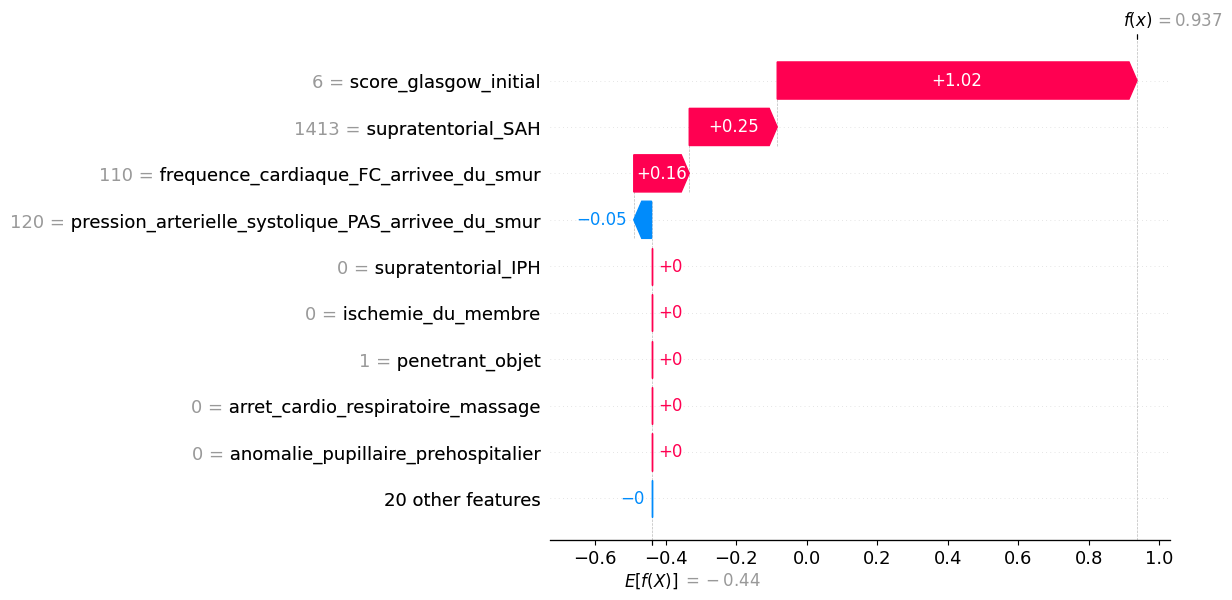

In [82]:
shap.plots.waterfall(shap_values2[12])

#### Confidence intervals with test set bootstrap

In [19]:
best_params_list = []

for estimator in nested_scores_smote_undersampling["estimator"]:
    best_params_list.append(frozenset(estimator.best_params_.items()))

In [20]:
from collections import Counter
# Convert dict to a hashable tuple and count occurrences
most_common_params = Counter(best_params_list).most_common(1)[0][0]
final_params = dict(most_common_params)  # Convert back to dict


print("Final chosen hyperparameters:", final_params)

Final chosen hyperparameters: {'over__k_neighbors': 3, 'over__sampling_strategy': 0.2, 'model__learning_rate': 0.01, 'under__sampling_strategy': 0.7}


In [21]:
pipeline = Pipeline(steps=[('over', SMOTE(k_neighbors=3, sampling_strategy=0.2)), ('under', RandomUnderSampler(sampling_strategy=0.7)), ('model', HistGradientBoostingClassifier(learning_rate=0.01))])

In [25]:
y_pred = cross_val_predict(pipeline, X_features_imputed, y_outcome, cv=20, method='predict_proba')[:,1]

y_pred_binary = [1 if i>=0.5 else 0 for i in y_pred]

In [26]:
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, f1_score, brier_score_loss

In [27]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(len(y_outcome))

y_pred = np.asarray(y_pred)
y_pred_binary = np.asarray(y_pred_binary)
y = np.asarray(y_outcome)
X_dropped = np.asarray(X_features_imputed)

test_roc_auc = []
test_f1 = []
test_ftwos = []
test_brier = []
test_false_neg = []
test_false_pos = []

for i in range(200): # bootstrap with 200 rounds: random sampling with replacement of the predictions

    pred_idx = rng.choice(idx, size=len(idx), replace=True)
    
    roc_auc_test_boot = roc_auc_score(y_score=y_pred[pred_idx], y_true=y[pred_idx])
    f1_test_boot = f1_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx])
    f2_test_boot = fbeta_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx], beta=2)
    brier_test_boot = brier_score_loss(y_proba=y_pred[pred_idx], y_true=y[pred_idx])
    false_neg_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[1,0]
    false_pos_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[0,1]
    
    test_roc_auc.append(roc_auc_test_boot)
    test_f1.append(f1_test_boot)
    test_ftwos.append(f2_test_boot)
    test_brier.append(brier_test_boot)
    test_false_neg.append(false_neg_test_boot/len(idx)*100)
    test_false_pos.append(false_pos_test_boot/len(idx)*100)


In [28]:
print("Classification performance\n")

bootstrap_roc_auc_test_mean = np.mean(test_roc_auc)
ci_lower = np.percentile(test_roc_auc, 2.5)     # 2.5 percentile (alpha=0.025)
ci_upper = np.percentile(test_roc_auc, 97.5)
print(f"ROC AUC:         {bootstrap_roc_auc_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f1_test_mean = np.mean(test_f1)
ci_lower = np.percentile(test_f1, 2.5)
ci_upper = np.percentile(test_f1, 97.5)
print(f"F1:              {bootstrap_f1_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f2_test_mean = np.mean(test_ftwos)
ci_lower = np.percentile(test_ftwos, 2.5)
ci_upper = np.percentile(test_ftwos, 97.5)
print(f"F2:              {bootstrap_f2_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_brier_test_mean = np.mean(test_brier)
ci_lower = np.percentile(test_brier, 2.5)
ci_upper = np.percentile(test_brier, 97.5)
print(f"Brier loss:      {bootstrap_brier_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_neg_test_mean = np.mean(test_false_neg)
ci_lower = np.percentile(test_false_neg, 2.5)
ci_upper = np.percentile(test_false_neg, 97.5)
print(f"False negatives: {bootstrap_false_neg_test_mean:.2f}%;  95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_pos_test_mean = np.mean(test_false_pos)
ci_lower = np.percentile(test_false_pos, 2.5)
ci_upper = np.percentile(test_false_pos, 97.5)
print(f"False negatives: {bootstrap_false_pos_test_mean:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

Classification performance

ROC AUC:         0.90;   95% CI 0.86-0.94
F1:              0.51;   95% CI 0.40-0.61
F2:              0.63;   95% CI 0.53-0.75
Brier loss:      0.10;   95% CI 0.09-0.11
False negatives: 2.09%;  95% CI 1.13-3.38
False negatives: 10.50%; 95% CI 7.88-13.14


### Gradient boosting with segmentation

In [29]:
X = pd.read_csv(DATA_DIRECTORY+"segmentation_data_anonymized.csv", usecols=range(1,16))
X.head()

y = get_til()

# Identify indexes where 'mortality' is NaN in y
try:
    nan_indexes = y.loc[pd.isna(y["mortality"]), :].index
except:
    nan_indexes=[]
print(f"Indexes with NaN in 'mortality': {nan_indexes}")

# Drop rows with NaN in y
y = y.drop(index=nan_indexes)

# Ensure 'name' is the index or used for alignment
X = X[~X['name'].isin(y.loc[nan_indexes, 'name'])]

# Verify the shapes after cleaning
print(f"Shape of y after cleaning: {y.shape}")
print(f"Shape of X after cleaning: {X.shape}")

# Vérifiez les valeurs uniques de 'name' dans y
print("Unique 'name' values in y:", y['name'].nunique())

# Vérifiez les valeurs uniques de 'name' dans X
print("Unique 'name' values in X:", X['name'].nunique())

# Noms dans y mais pas dans X
missing_in_X = set(y['name']) - set(X['name'])
print(f"Names in y but not in X: {missing_in_X}")

# Noms dans X mais pas dans y
missing_in_y = set(X['name']) - set(y['name'])
print(f"Names in X but not in y: {missing_in_y}")

# Trouver les noms communs
common_names = set(y['name']).intersection(set(X['name']))

# Filtrer y et X pour ne garder que les noms communs
y = y[y['name'].isin(common_names)]
X = X[X['name'].isin(common_names)]

# Vérifiez les dimensions après nettoyage
print(f"Shape of y after alignment: {y.shape}")
print(f"Shape of X after alignment: {X.shape}")

# Check for duplicates in 'name' in y
print("Number of duplicate names in y:", y['name'].duplicated().sum())

# Check for duplicates in 'name' in X
print("Number of duplicate names in X:", X['name'].duplicated().sum())

# Remove duplicates from both DataFrames
y = y.drop_duplicates(subset=['name'])
X = X.drop_duplicates(subset=['name'])

# Verify the shapes again
print(f"Shape of y after removing duplicates: {y.shape}")
print(f"Shape of X after removing duplicates: {X.shape}")

# Check if 'name' values are the same in both DataFrames
common_names = set(y['name']) == set(X['name'])
print(f"Are 'name' values aligned between y and X {common_names}")

# Trier y et X par la colonne 'name'
y = y.sort_values(by='name').reset_index(drop=True)
X = X.sort_values(by='name').reset_index(drop=True)

# Vérifier si les noms sont alignés
print((y['name'].values == X['name'].values).all())

# Drop the 'name' column from X
X_features = X.drop(columns=['name'])

# imputation with median 
X_features_imputed = X_features.fillna(X_features.median())

# Drop the 'name' column from y (if it exists)
y_outcome = y.drop(columns=['name'])

# Ensure y_outcome is a 1D array
y_outcome = y_outcome.values.ravel()  # Convert to 1D if using pandas DataFrame

    name  TIL 0  TIL 1  TIL 2  TIL 3 TIL 4
1  P0001    0.0    0.0    0.0    0.0     0
2  P0002    0.0    0.0    0.0    0.0     0
3  P0003    0.0    0.0    0.0    0.0     0
4  P0004    0.0    0.0    0.0    0.0     0
5  P0005    0.0    0.0    0.0    0.0     0
    name  TIL_bin
1  P0001        0
2  P0002        0
3  P0003        0
4  P0004        0
5  P0005        0
Outcome events: 46
Indexes with NaN in 'mortality': []
Shape of y after cleaning: (565, 2)
Shape of X after cleaning: (534, 15)
Unique 'name' values in y: 561
Unique 'name' values in X: 534
Names in y but not in X: {'P0155', 'P0239', 'P0147', 'P0224', 'P0430', 'P0018', 'P0150', 'P0422', 'P0527', 'P0518', 'P0207', 'P0349', 'P0412', 'P0343', 'P0564', 'P0083', 'P0010', 'P0491', 'P0149', 'P0111', 'P0369', 'P0383', 'P0356', 'P0217', 'P0195', 'P0480', 'P0532', 'P0327'}
Names in X but not in y: {'P0000'}
Shape of y after alignment: (535, 2)
Shape of X after alignment: (533, 15)
Number of duplicate names in y: 2
Number of duplicate na

In [30]:
num_ones = np.sum(y_outcome == 1)  # True values are treated as 1 in numpy
print(f"Number of y = 1 in y_outcome: {num_ones}")

Number of y = 1 in y_outcome: 46


In [31]:
FOLDS = 5
N_REPEATS = 3
nb_total_samples = len(y_outcome)

pipeline_smote_under = Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])
#pipeline_smote_under = Pipeline(steps=[('over', SMOTENC(categorical_features=["fracas_du_bassin", "amputation"])), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])


inner_cv = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=5, random_state=1)

p_grid = {"model__learning_rate": [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1], "over__sampling_strategy": [0.1, 0.2, 0.3], "over__k_neighbors":[3,5,8], "under__sampling_strategy":[0.3, 0.5, 0.7]}
clf = GridSearchCV(estimator=pipeline_smote_under, param_grid=p_grid, scoring={'F2':ftwo_scorer}, refit='F2', cv=inner_cv)

outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

nested_scores_smote_undersampling = cross_validate(clf, X_features_imputed, y_outcome, 
                                                   scoring={'F2':ftwo_scorer, 'ROC_AUC':'roc_auc', 'Recall':'recall_macro', 'F1':'f1', 'Brier':"neg_brier_score", 'False_neg_scorer':false_neg_scorer, 'False_pos_scorer':false_pos_scorer}, 
                                                   cv=outer_cv, n_jobs=-1, return_estimator=True, return_indices=True)

print("HistGradientBoostingClassifier with hyperparameter gridsearch")

roc_auc_metric = np.mean(nested_scores_smote_undersampling["test_ROC_AUC"])
roc_auc_metric_std = np.std(nested_scores_smote_undersampling["test_ROC_AUC"])
print(f'AUC (max): {np.round(roc_auc_metric, 2)} +- {np.round(roc_auc_metric_std, 2)}')

f1_score = np.mean(nested_scores_smote_undersampling["test_F1"])
f1_score_std = np.std(nested_scores_smote_undersampling["test_F1"])
print(f'F1 Score (max): {np.round(f1_score, 2)} +- {np.round(f1_score_std, 2)}')

f2_score = np.mean(nested_scores_smote_undersampling["test_F2"])
f2_score_std = np.std(nested_scores_smote_undersampling["test_F2"])
print(f'F2 Score (max): {np.round(f2_score, 2)} +- {np.round(f2_score_std, 2)}')

brier_score = -np.mean(nested_scores_smote_undersampling["test_Brier"])
brier_score_std = -np.std(nested_scores_smote_undersampling["test_Brier"])
print(f'Brier Score (min): {np.round(brier_score, 2)} +- {np.round(brier_score_std, 2)}')

# test_False_neg_scorer returns the number of test false negatives -> to get a % we need to divide by the number of test samples*100
false_neg_score = np.mean(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
false_neg_score_std = np.std(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
print(f'False negative: {int(np.round(false_neg_score, 0))}% +- {int(np.round(false_neg_score_std, 0))}')

false_pos_score = np.mean(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
false_pos_score_std = np.std(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
print(f'False positive: {int(np.round(false_pos_score, 0))}% +- {int(np.round(false_pos_score_std, 0))}')

/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(

HistGradientBoostingClassifier with hyperparameter gridsearch
AUC (max): 0.87 +- 0.06
F1 Score (max): 0.44 +- 0.09
F2 Score (max): 0.54 +- 0.12
Brier Score (min): 0.11 +- -0.02
False negative: 3% +- 1
False positive: 11% +- 3


#### Confidence intervals with test set bootstrap

In [32]:
best_params_list = []

for estimator in nested_scores_smote_undersampling["estimator"]:
    best_params_list.append(frozenset(estimator.best_params_.items()))

In [33]:
from collections import Counter
# Convert dict to a hashable tuple and count occurrences
most_common_params = Counter(best_params_list).most_common(1)[0][0]
final_params = dict(most_common_params)  # Convert back to dict


print("Final chosen hyperparameters:", final_params)

Final chosen hyperparameters: {'over__sampling_strategy': 0.3, 'over__k_neighbors': 3, 'under__sampling_strategy': 0.7, 'model__learning_rate': 0.01}


In [34]:
pipeline = Pipeline(steps=[('over', SMOTE(k_neighbors=3, sampling_strategy=0.3)), ('under', RandomUnderSampler(sampling_strategy=0.7)), ('model', HistGradientBoostingClassifier(learning_rate=0.01))])

In [35]:
y_pred = cross_val_predict(pipeline, X_features_imputed, y_outcome, cv=20, method='predict_proba')[:,1]

y_pred_binary = [1 if i>=0.5 else 0 for i in y_pred]

In [36]:
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, f1_score, brier_score_loss

In [37]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(len(y_outcome))

y_pred = np.asarray(y_pred)
y_pred_binary = np.asarray(y_pred_binary)
y = np.asarray(y_outcome)
X_dropped = np.asarray(X_features_imputed)

test_roc_auc = []
test_f1 = []
test_ftwos = []
test_brier = []
test_false_neg = []
test_false_pos = []

for i in range(200): # bootstrap with 200 rounds: random sampling with replacement of the predictions

    pred_idx = rng.choice(idx, size=len(idx), replace=True)
    
    roc_auc_test_boot = roc_auc_score(y_score=y_pred[pred_idx], y_true=y[pred_idx])
    f1_test_boot = f1_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx])
    f2_test_boot = fbeta_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx], beta=2)
    brier_test_boot = brier_score_loss(y_proba=y_pred[pred_idx], y_true=y[pred_idx])
    false_neg_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[1,0]
    false_pos_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[0,1]
    
    test_roc_auc.append(roc_auc_test_boot)
    test_f1.append(f1_test_boot)
    test_ftwos.append(f2_test_boot)
    test_brier.append(brier_test_boot)
    test_false_neg.append(false_neg_test_boot/len(idx)*100)
    test_false_pos.append(false_pos_test_boot/len(idx)*100)


In [38]:
print("Classification performance\n")

bootstrap_roc_auc_test_mean = np.mean(test_roc_auc)
ci_lower = np.percentile(test_roc_auc, 2.5)     # 2.5 percentile (alpha=0.025)
ci_upper = np.percentile(test_roc_auc, 97.5)
print(f"ROC AUC:         {bootstrap_roc_auc_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f1_test_mean = np.mean(test_f1)
ci_lower = np.percentile(test_f1, 2.5)
ci_upper = np.percentile(test_f1, 97.5)
print(f"F1:              {bootstrap_f1_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f2_test_mean = np.mean(test_ftwos)
ci_lower = np.percentile(test_ftwos, 2.5)
ci_upper = np.percentile(test_ftwos, 97.5)
print(f"F2:              {bootstrap_f2_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_brier_test_mean = np.mean(test_brier)
ci_lower = np.percentile(test_brier, 2.5)
ci_upper = np.percentile(test_brier, 97.5)
print(f"Brier loss:      {bootstrap_brier_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_neg_test_mean = np.mean(test_false_neg)
ci_lower = np.percentile(test_false_neg, 2.5)
ci_upper = np.percentile(test_false_neg, 97.5)
print(f"False negatives: {bootstrap_false_neg_test_mean:.2f}%;  95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_pos_test_mean = np.mean(test_false_pos)
ci_lower = np.percentile(test_false_pos, 2.5)
ci_upper = np.percentile(test_false_pos, 97.5)
print(f"False negatives: {bootstrap_false_pos_test_mean:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

Classification performance

ROC AUC:         0.90;   95% CI 0.85-0.93
F1:              0.47;   95% CI 0.38-0.57
F2:              0.58;   95% CI 0.49-0.69
Brier loss:      0.10;   95% CI 0.09-0.11
False negatives: 2.65%;  95% CI 1.31-4.13
False negatives: 10.67%; 95% CI 8.25-13.14


### Gradient boosting with traumatrix model

In [39]:
X = pd.read_csv(DATA_DIRECTORY+"segmentation_data_anonymized.csv", usecols=[1]+list(range(16,31)))
X.head()

,name,age,hemocue_initial,fracas_du_bassin,catecholamines,pression_arterielle_systolique_PAS_arrivee_du_smur,pression_arterielle_diastolique_PAD_arrivee_du_smur,score_glasgow_initial,score_glasgow_moteur_initial,anomalie_pupillaire_prehospitalier,frequence_cardiaque_FC_arrivee_du_smur,arret_cardio_respiratoire_massage,penetrant_objet,ischemie_du_membre,hemorragie_externe,amputation
0,P0001,52.0,NaN,0.0,0.0,87.0,49.0,15.0,6.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0
1,P0002,23.0,NaN,0.0,0.0,100.0,60.0,15.0,6.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,P0003,42.0,13.1,0.0,0.0,101.0,64.0,14.0,6.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0
3,P0004,34.0,15.8,0.0,0.0,110.0,71.0,15.0,6.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0
4,P0005,22.0,NaN,0.0,0.0,114.0,79.0,NaN,NaN,0.0,83.0,0.0,0.0,0.0,0.0,0.0


In [40]:


y = get_til()

# Identify indexes where 'mortality' is NaN in y
try:
    nan_indexes = y.loc[pd.isna(y["mortality"]), :].index
except:
    nan_indexes=[]
print(f"Indexes with NaN in 'mortality': {nan_indexes}")

# Drop rows with NaN in y
y = y.drop(index=nan_indexes)

# Ensure 'name' is the index or used for alignment
X = X[~X['name'].isin(y.loc[nan_indexes, 'name'])]

# Verify the shapes after cleaning
print(f"Shape of y after cleaning: {y.shape}")
print(f"Shape of X after cleaning: {X.shape}")

# Vérifiez les valeurs uniques de 'name' dans y
print("Unique 'name' values in y:", y['name'].nunique())

# Vérifiez les valeurs uniques de 'name' dans X
print("Unique 'name' values in X:", X['name'].nunique())

# Noms dans y mais pas dans X
missing_in_X = set(y['name']) - set(X['name'])
print(f"Names in y but not in X: {missing_in_X}")

# Noms dans X mais pas dans y
missing_in_y = set(X['name']) - set(y['name'])
print(f"Names in X but not in y: {missing_in_y}")

# Trouver les noms communs
common_names = set(y['name']).intersection(set(X['name']))

# Filtrer y et X pour ne garder que les noms communs
y = y[y['name'].isin(common_names)]
X = X[X['name'].isin(common_names)]

# Vérifiez les dimensions après nettoyage
print(f"Shape of y after alignment: {y.shape}")
print(f"Shape of X after alignment: {X.shape}")

# Check for duplicates in 'name' in y
print("Number of duplicate names in y:", y['name'].duplicated().sum())

# Check for duplicates in 'name' in X
print("Number of duplicate names in X:", X['name'].duplicated().sum())

# Remove duplicates from both DataFrames
y = y.drop_duplicates(subset=['name'])
X = X.drop_duplicates(subset=['name'])

# Verify the shapes again
print(f"Shape of y after removing duplicates: {y.shape}")
print(f"Shape of X after removing duplicates: {X.shape}")

# Check if 'name' values are the same in both DataFrames
common_names = set(y['name']) == set(X['name'])
print(f"Are 'name' values aligned between y and X {common_names}")

# Trier y et X par la colonne 'name'
y = y.sort_values(by='name').reset_index(drop=True)
X = X.sort_values(by='name').reset_index(drop=True)

# Vérifier si les noms sont alignés
print((y['name'].values == X['name'].values).all())

# Drop the 'name' column from X
X_features = X.drop(columns=['name'])

# imputation with median 
X_features_imputed = X_features.fillna(X_features.median())

# Drop the 'name' column from y (if it exists)
y_outcome = y.drop(columns=['name'])

# Ensure y_outcome is a 1D array
y_outcome = y_outcome.values.ravel()  # Convert to 1D if using pandas DataFrame

    name  TIL 0  TIL 1  TIL 2  TIL 3 TIL 4
1  P0001    0.0    0.0    0.0    0.0     0
2  P0002    0.0    0.0    0.0    0.0     0
3  P0003    0.0    0.0    0.0    0.0     0
4  P0004    0.0    0.0    0.0    0.0     0
5  P0005    0.0    0.0    0.0    0.0     0
    name  TIL_bin
1  P0001        0
2  P0002        0
3  P0003        0
4  P0004        0
5  P0005        0
Outcome events: 46
Indexes with NaN in 'mortality': []
Shape of y after cleaning: (565, 2)
Shape of X after cleaning: (534, 16)
Unique 'name' values in y: 561
Unique 'name' values in X: 534
Names in y but not in X: {'P0155', 'P0239', 'P0147', 'P0224', 'P0430', 'P0018', 'P0150', 'P0422', 'P0527', 'P0518', 'P0207', 'P0349', 'P0412', 'P0343', 'P0564', 'P0083', 'P0010', 'P0491', 'P0149', 'P0111', 'P0369', 'P0383', 'P0356', 'P0217', 'P0195', 'P0480', 'P0532', 'P0327'}
Names in X but not in y: {'P0000'}
Shape of y after alignment: (535, 2)
Shape of X after alignment: (533, 16)
Number of duplicate names in y: 2
Number of duplicate na

In [41]:
pipeline_smote_under_traumatrix = Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])
#pipeline_smote_under = Pipeline(steps=[('over', SMOTENC(categorical_features=["fracas_du_bassin", "amputation"])), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])


inner_cv_traumatrix = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=5, random_state=1)

p_grid = {"model__learning_rate": [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1], "over__sampling_strategy": [0.1, 0.2, 0.3], "over__k_neighbors":[3,5,8], "under__sampling_strategy":[0.3, 0.5, 0.7]}
clf_traumatrix = GridSearchCV(estimator=pipeline_smote_under_traumatrix, param_grid=p_grid, scoring={'F2':ftwo_scorer}, refit='F2', cv=inner_cv_traumatrix)

outer_cv_traumatrix = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

nested_scores_smote_undersampling_traumatrix = cross_validate(clf_traumatrix, X_features_imputed, y_outcome, 
                                                   scoring={'F2':ftwo_scorer, 'ROC_AUC':'roc_auc', 'Recall':'recall_macro', 'F1':'f1', 'Brier':"neg_brier_score", 'False_neg_scorer':false_neg_scorer, 'False_pos_scorer':false_pos_scorer}, 
                                                   cv=outer_cv_traumatrix, n_jobs=-1, return_estimator=True, return_indices=True)

print("HistGradientBoostingClassifier with hyperparameter gridsearch")

roc_auc_metric = np.mean(nested_scores_smote_undersampling_traumatrix["test_ROC_AUC"])
roc_auc_metric_std = np.std(nested_scores_smote_undersampling_traumatrix["test_ROC_AUC"])
print(f'AUC (max): {np.round(roc_auc_metric, 2)} +- {np.round(roc_auc_metric_std, 2)}')

f1_score = np.mean(nested_scores_smote_undersampling_traumatrix["test_F1"])
f1_score_std = np.std(nested_scores_smote_undersampling_traumatrix["test_F1"])
print(f'F1 Score (max): {np.round(f1_score, 2)} +- {np.round(f1_score_std, 2)}')

f2_score = np.mean(nested_scores_smote_undersampling_traumatrix["test_F2"])
f2_score_std = np.std(nested_scores_smote_undersampling_traumatrix["test_F2"])
print(f'F2 Score (max): {np.round(f2_score, 2)} +- {np.round(f2_score_std, 2)}')

brier_score = -np.mean(nested_scores_smote_undersampling_traumatrix["test_Brier"])
brier_score_std = -np.std(nested_scores_smote_undersampling_traumatrix["test_Brier"])
print(f'Brier Score (min): {np.round(brier_score, 2)} +- {np.round(brier_score_std, 2)}')

# test_False_neg_scorer returns the number of test false negatives -> to get a % we need to divide by the number of test samples*100
false_neg_score = np.mean(nested_scores_smote_undersampling_traumatrix["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
false_neg_score_std = np.std(nested_scores_smote_undersampling_traumatrix["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
print(f'False negative: {int(np.round(false_neg_score, 0))}% +- {int(np.round(false_neg_score_std, 0))}')

false_pos_score = np.mean(nested_scores_smote_undersampling_traumatrix["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
false_pos_score_std = np.std(nested_scores_smote_undersampling_traumatrix["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
print(f'False positive: {int(np.round(false_pos_score, 0))}% +- {int(np.round(false_pos_score_std, 0))}')

/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


HistGradientBoostingClassifier with hyperparameter gridsearch
AUC (max): 0.87 +- 0.05
F1 Score (max): 0.52 +- 0.07
F2 Score (max): 0.66 +- 0.08
Brier Score (min): 0.11 +- -0.02
False negative: 2% +- 1
False positive: 11% +- 3


#### Confidence intervals with test set bootstrap

In [42]:
best_params_list = []

for estimator in nested_scores_smote_undersampling_traumatrix["estimator"]:
    best_params_list.append(frozenset(estimator.best_params_.items()))

In [43]:
from collections import Counter
# Convert dict to a hashable tuple and count occurrences
most_common_params = Counter(best_params_list).most_common(1)[0][0]
final_params = dict(most_common_params)  # Convert back to dict


print("Final chosen hyperparameters:", final_params)

Final chosen hyperparameters: {'over__k_neighbors': 8, 'under__sampling_strategy': 0.7, 'model__learning_rate': 0.01, 'over__sampling_strategy': 0.1}


In [44]:
pipeline = Pipeline(steps=[('over', SMOTE(k_neighbors=8, sampling_strategy=0.1)), ('under', RandomUnderSampler(sampling_strategy=0.7)), ('model', HistGradientBoostingClassifier(learning_rate=0.01))])

In [45]:
y_pred = cross_val_predict(pipeline, X_features_imputed, y_outcome, cv=20, method='predict_proba')[:,1]

y_pred_binary = [1 if i>=0.5 else 0 for i in y_pred]

In [46]:
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, f1_score, brier_score_loss

In [47]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(len(y_outcome))

y_pred = np.asarray(y_pred)
y_pred_binary = np.asarray(y_pred_binary)
y = np.asarray(y_outcome)
X_dropped = np.asarray(X_features_imputed)

test_roc_auc = []
test_f1 = []
test_ftwos = []
test_brier = []
test_false_neg = []
test_false_pos = []

for i in range(200): # bootstrap with 200 rounds: random sampling with replacement of the predictions

    pred_idx = rng.choice(idx, size=len(idx), replace=True)
    
    roc_auc_test_boot = roc_auc_score(y_score=y_pred[pred_idx], y_true=y[pred_idx])
    f1_test_boot = f1_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx])
    f2_test_boot = fbeta_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx], beta=2)
    brier_test_boot = brier_score_loss(y_proba=y_pred[pred_idx], y_true=y[pred_idx])
    false_neg_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[1,0]
    false_pos_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[0,1]
    
    test_roc_auc.append(roc_auc_test_boot)
    test_f1.append(f1_test_boot)
    test_ftwos.append(f2_test_boot)
    test_brier.append(brier_test_boot)
    test_false_neg.append(false_neg_test_boot/len(idx)*100)
    test_false_pos.append(false_pos_test_boot/len(idx)*100)


In [48]:
print("Classification performance\n")

bootstrap_roc_auc_test_mean = np.mean(test_roc_auc)
ci_lower = np.percentile(test_roc_auc, 2.5)     # 2.5 percentile (alpha=0.025)
ci_upper = np.percentile(test_roc_auc, 97.5)
print(f"ROC AUC:         {bootstrap_roc_auc_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f1_test_mean = np.mean(test_f1)
ci_lower = np.percentile(test_f1, 2.5)
ci_upper = np.percentile(test_f1, 97.5)
print(f"F1:              {bootstrap_f1_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f2_test_mean = np.mean(test_ftwos)
ci_lower = np.percentile(test_ftwos, 2.5)
ci_upper = np.percentile(test_ftwos, 97.5)
print(f"F2:              {bootstrap_f2_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_brier_test_mean = np.mean(test_brier)
ci_lower = np.percentile(test_brier, 2.5)
ci_upper = np.percentile(test_brier, 97.5)
print(f"Brier loss:      {bootstrap_brier_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_neg_test_mean = np.mean(test_false_neg)
ci_lower = np.percentile(test_false_neg, 2.5)
ci_upper = np.percentile(test_false_neg, 97.5)
print(f"False negatives: {bootstrap_false_neg_test_mean:.2f}%;  95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_pos_test_mean = np.mean(test_false_pos)
ci_lower = np.percentile(test_false_pos, 2.5)
ci_upper = np.percentile(test_false_pos, 97.5)
print(f"False negatives: {bootstrap_false_pos_test_mean:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

Classification performance

ROC AUC:         0.87;   95% CI 0.81-0.92
F1:              0.52;   95% CI 0.42-0.61
F2:              0.67;   95% CI 0.58-0.76
Brier loss:      0.11;   95% CI 0.10-0.12
False negatives: 1.54%;  95% CI 0.56-2.63
False negatives: 11.45%; 95% CI 9.00-14.08


### Gradient boosting with all prehospital features

In [4]:
# run preprocessing outcome mortality

In [5]:

data_full = pd.read_csv(DATA_DIRECTORY+"final_database_clinical_segmentation.csv")
data_full.head()

,Unnamed: 0,Unnamed: 0_x,name,Date Naissance,Age,Sexe,Venue,Entrée venue,Unnamed: 9,Exclusion,...,score_glasgow_initial,score_glasgow_moteur_initial,anomalie_pupillaire_prehospitalier,frequence_cardiaque_FC_arrivee_du_smur,arret_cardio_respiratoire_massage,penetrant_objet,ischemie_du_membre,hemorragie_externe,amputation,outcome_neurochir_pic
0,0,0,P0000,11/19/1941,NaN,M,2.000010e+12,8/5/2020 21:36,NaN,NaN,...,15.0,6.0,0.0,137.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,P0001,11/21/1968,NaN,M,2.000010e+12,8/6/2020 11:50,NaN,NaN,...,15.0,6.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,P0002,6/14/1997,NaN,M,2.000010e+12,8/7/2020 21:31,NaN,NaN,...,15.0,6.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,P0003,8/5/1978,NaN,F,2.000010e+12,8/8/2020 19:57,NaN,NaN,...,14.0,6.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,P0004,11/17/1986,NaN,M,2.000010e+12,8/9/2020 2:19,NaN,NaN,...,15.0,6.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Select columns 16 to 36
X_prehosp = data_full.iloc[:, 15:35]

# Convert all columns to numeric, replacing non-numeric values and empty strings with NaN
X_prehosp = X_prehosp.apply(pd.to_numeric, errors='coerce')

# Include column name
X_prehosp = pd.concat([X_prehosp, data_full.iloc[:, 2]], axis=1)

In [7]:



# Verify if there are NaN values
print(f"Number of NaN values per column:\n{X_prehosp.isna().sum()}")

# Display the resulting DataFrame
X_prehosp.head()

Number of NaN values per column:
PAS  SMUR                   40
PAD  SMUR                   49
FC SMUR                     42
FR SMUR                    485
Shock Index SMUR            55
GCS SMUR                    17
GCS (M) SMUR                30
Hémocue SMUR               243
Shock Index inversé         54
Shock index diastolique     62
Anomalie pupille SMUR       17
Fracas bassin               14
Amputation                  12
ACR SMUR                    11
Hémorragie ext SMUR         12
Ischémie                    12
Intubation prehosp          11
Expansion volémique         20
OsmoTH prehosp              11
Vasopresseur prehosp        12
name                         0
dtype: int64


,PAS SMUR,PAD SMUR,FC SMUR,FR SMUR,Shock Index SMUR,GCS SMUR,GCS (M) SMUR,Hémocue SMUR,Shock Index inversé,Shock index diastolique,...,Fracas bassin,Amputation,ACR SMUR,Hémorragie ext SMUR,Ischémie,Intubation prehosp,Expansion volémique,OsmoTH prehosp,Vasopresseur prehosp,name
0,190.0,103.0,137.0,NaN,0.72,15.0,6.0,NaN,1.39,1.33,...,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,P0000
1,87.0,49.0,56.0,NaN,0.64,15.0,6.0,NaN,1.55,1.14,...,0.0,0.0,0.0,0.0,0.0,0.0,250.0,0.0,0.0,P0001
2,100.0,60.0,100.0,17.0,1.00,15.0,6.0,NaN,1.00,1.67,...,0.0,0.0,0.0,0.0,0.0,0.0,250.0,0.0,0.0,P0002
3,101.0,64.0,120.0,NaN,1.19,14.0,6.0,13.1,0.84,1.88,...,0.0,0.0,0.0,0.0,0.0,0.0,250.0,0.0,0.0,P0003
4,110.0,71.0,107.0,18.0,0.97,15.0,6.0,15.8,1.03,1.51,...,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,P0004


In [8]:
X = X_prehosp.copy()
y = get_til()

    name  TIL 0  TIL 1  TIL 2  TIL 3 TIL 4
1  P0001    0.0    0.0    0.0    0.0     0
2  P0002    0.0    0.0    0.0    0.0     0
3  P0003    0.0    0.0    0.0    0.0     0
4  P0004    0.0    0.0    0.0    0.0     0
5  P0005    0.0    0.0    0.0    0.0     0
    name  TIL_bin
1  P0001        0
2  P0002        0
3  P0003        0
4  P0004        0
5  P0005        0
Outcome events: 46


In [9]:
# Identify indexes where 'mortality' is NaN in y
nan_indexes = y.loc[pd.isna(y["TIL_bin"]), :].index
print(f"Indexes with NaN in 'mortality': {nan_indexes}")

# Drop rows with NaN in y
y = y.drop(index=nan_indexes)

# Ensure 'name' is the index or used for alignment
X = X[~X['name'].isin(y.loc[nan_indexes, 'name'])]

# Verify the shapes after cleaning
print(f"Shape of y after cleaning: {y.shape}")
print(f"Shape of X after cleaning: {X.shape}")

# Vérifiez les valeurs uniques de 'name' dans y
print("Unique 'name' values in y:", y['name'].nunique())

# Vérifiez les valeurs uniques de 'name' dans X
print("Unique 'name' values in X:", X['name'].nunique())

# Noms dans y mais pas dans X
missing_in_X = set(y['name']) - set(X['name'])
print(f"Names in y but not in X: {missing_in_X}")

# Noms dans X mais pas dans y
missing_in_y = set(X['name']) - set(y['name'])
print(f"Names in X but not in y: {missing_in_y}")

# Trouver les noms communs
common_names = set(y['name']).intersection(set(X['name']))

# Filtrer y et X pour ne garder que les noms communs
y = y[y['name'].isin(common_names)]
X = X[X['name'].isin(common_names)]

# Vérifiez les dimensions après nettoyage
print(f"Shape of y after alignment: {y.shape}")
print(f"Shape of X after alignment: {X.shape}")

# Check for duplicates in 'name' in y
print("Number of duplicate names in y:", y['name'].duplicated().sum())

# Check for duplicates in 'name' in X
print("Number of duplicate names in X:", X['name'].duplicated().sum())

# Remove duplicates from both DataFrames
y = y.drop_duplicates(subset=['name'])
X = X.drop_duplicates(subset=['name'])

# Verify the shapes again
print(f"Shape of y after removing duplicates: {y.shape}")
print(f"Shape of X after removing duplicates: {X.shape}")

# Check if 'name' values are the same in both DataFrames
common_names = set(y['name']) == set(X['name'])
print(f"Are 'name' values aligned between y and X {common_names}")

# Drop the 'name' column from X_volumes_clinical_with_outcome
X_features = X.drop(columns=['name'])

# imputation with median 
X_features_imputed = X_features.fillna(X_features.median())

# Drop the 'name' column from y (if it exists)
y_outcome = y.drop(columns=['name'])

# Ensure y_outcome is a 1D array
y_outcome = y_outcome.values.ravel()  # Convert to 1D if using pandas DataFrame

FOLDS = 5
N_REPEATS = 3
nb_total_samples = len(y_outcome)

Indexes with NaN in 'mortality': Index([], dtype='int64')
Shape of y after cleaning: (565, 2)
Shape of X after cleaning: (534, 21)
Unique 'name' values in y: 561
Unique 'name' values in X: 534
Names in y but not in X: {'P0239', 'P0083', 'P0195', 'P0532', 'P0147', 'P0356', 'P0150', 'P0224', 'P0343', 'P0527', 'P0327', 'P0149', 'P0430', 'P0155', 'P0369', 'P0518', 'P0422', 'P0111', 'P0018', 'P0480', 'P0010', 'P0491', 'P0412', 'P0349', 'P0564', 'P0217', 'P0383', 'P0207'}
Names in X but not in y: {'P0000'}
Shape of y after alignment: (535, 2)
Shape of X after alignment: (533, 21)
Number of duplicate names in y: 2
Number of duplicate names in X: 0
Shape of y after removing duplicates: (533, 2)
Shape of X after removing duplicates: (533, 21)
Are 'name' values aligned between y and X True


In [10]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [11]:

pipeline_smote_under = Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])
#pipeline_smote_under = Pipeline(steps=[('over', SMOTENC(categorical_features=["fracas_du_bassin", "amputation"])), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])


inner_cv = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=5, random_state=1)

p_grid = {"model__learning_rate": [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1], "over__sampling_strategy": [0.1, 0.2, 0.3], "over__k_neighbors":[3,5,8], "under__sampling_strategy":[0.3, 0.5, 0.7]}
clf = GridSearchCV(estimator=pipeline_smote_under, param_grid=p_grid, scoring={'F2':ftwo_scorer}, refit='F2', cv=inner_cv)

outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

nested_scores_smote_undersampling = cross_validate(clf, X_features_imputed, y_outcome, 
                                                scoring={'F2':ftwo_scorer, 'ROC_AUC':'roc_auc', 'Recall':'recall_macro', 'F1':'f1', 'Brier':"neg_brier_score", 'False_neg_scorer':false_neg_scorer, 'False_pos_scorer':false_pos_scorer}, 
                                                cv=outer_cv, n_jobs=-1, return_estimator=True, return_indices=True)

print("HistGradientBoostingClassifier with hyperparameter gridsearch")

roc_auc_metric = np.mean(nested_scores_smote_undersampling["test_ROC_AUC"])
roc_auc_metric_std = np.std(nested_scores_smote_undersampling["test_ROC_AUC"])
print(f'AUC (max): {np.round(roc_auc_metric, 2)} +- {np.round(roc_auc_metric_std, 2)}')

f1_score = np.mean(nested_scores_smote_undersampling["test_F1"])
f1_score_std = np.std(nested_scores_smote_undersampling["test_F1"])
print(f'F1 Score (max): {np.round(f1_score, 2)} +- {np.round(f1_score_std, 2)}')

f2_score = np.mean(nested_scores_smote_undersampling["test_F2"])
f2_score_std = np.std(nested_scores_smote_undersampling["test_F2"])
print(f'F2 Score (max): {np.round(f2_score, 2)} +- {np.round(f2_score_std, 2)}')

brier_score = -np.mean(nested_scores_smote_undersampling["test_Brier"])
brier_score_std = -np.std(nested_scores_smote_undersampling["test_Brier"])
print(f'Brier Score (min): {np.round(brier_score, 2)} +- {np.round(brier_score_std, 2)}')

# test_False_neg_scorer returns the number of test false negatives -> to get a % we need to divide by the number of test samples*100
false_neg_score = np.mean(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
false_neg_score_std = np.std(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
print(f'False negative: {int(np.round(false_neg_score, 0))}% +- {int(np.round(false_neg_score_std, 0))}')

false_pos_score = np.mean(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
false_pos_score_std = np.std(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
print(f'False positive: {int(np.round(false_pos_score, 0))}% +- {int(np.round(false_pos_score_std, 0))}')

HistGradientBoostingClassifier with hyperparameter gridsearch
AUC (max): 0.87 +- 0.06
F1 Score (max): 0.52 +- 0.08
F2 Score (max): 0.66 +- 0.08
Brier Score (min): 0.11 +- -0.02
False negative: 2% +- 1
False positive: 12% +- 5


#### Confidence intervals with test set bootstrap

In [12]:
best_params_list = []

for estimator in nested_scores_smote_undersampling["estimator"]:
    best_params_list.append(frozenset(estimator.best_params_.items()))

In [13]:
from collections import Counter
# Convert dict to a hashable tuple and count occurrences
most_common_params = Counter(best_params_list).most_common(1)[0][0]
final_params = dict(most_common_params)  # Convert back to dict


print("Final chosen hyperparameters:", final_params)

Final chosen hyperparameters: {'model__learning_rate': 0.01, 'over__k_neighbors': 8, 'under__sampling_strategy': 0.7, 'over__sampling_strategy': 0.1}


In [14]:
print(final_params["model__learning_rate"])

0.01


In [15]:
pipeline = Pipeline(steps=[
    ('over', SMOTE(k_neighbors=final_params["over__k_neighbors"], sampling_strategy=final_params["over__sampling_strategy"])), 
    ('under', RandomUnderSampler(sampling_strategy=final_params["under__sampling_strategy"])), 
    ('model', HistGradientBoostingClassifier(learning_rate=final_params["model__learning_rate"]))])

In [16]:
y_pred = cross_val_predict(pipeline, X_features_imputed, y_outcome, cv=20, method='predict_proba')[:,1]

y_pred_binary = [1 if i>=0.5 else 0 for i in y_pred]

In [17]:
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, f1_score, brier_score_loss

In [18]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(len(y_outcome))

y_pred = np.asarray(y_pred)
y_pred_binary = np.asarray(y_pred_binary)
y = np.asarray(y_outcome)
X_dropped = np.asarray(X_features_imputed)

test_roc_auc = []
test_f1 = []
test_ftwos = []
test_brier = []
test_false_neg = []
test_false_pos = []

for i in range(200): # bootstrap with 200 rounds: random sampling with replacement of the predictions

    pred_idx = rng.choice(idx, size=len(idx), replace=True)
    
    roc_auc_test_boot = roc_auc_score(y_score=y_pred[pred_idx], y_true=y[pred_idx])
    f1_test_boot = f1_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx])
    f2_test_boot = fbeta_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx], beta=2)
    brier_test_boot = brier_score_loss(y_proba=y_pred[pred_idx], y_true=y[pred_idx])
    false_neg_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[1,0]
    false_pos_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[0,1]
    
    test_roc_auc.append(roc_auc_test_boot)
    test_f1.append(f1_test_boot)
    test_ftwos.append(f2_test_boot)
    test_brier.append(brier_test_boot)
    test_false_neg.append(false_neg_test_boot/len(idx)*100)
    test_false_pos.append(false_pos_test_boot/len(idx)*100)


In [19]:
print("Classification performance\n")

bootstrap_roc_auc_test_mean = np.mean(test_roc_auc)
ci_lower = np.percentile(test_roc_auc, 2.5)     # 2.5 percentile (alpha=0.025)
ci_upper = np.percentile(test_roc_auc, 97.5)
print(f"ROC AUC:         {bootstrap_roc_auc_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f1_test_mean = np.mean(test_f1)
ci_lower = np.percentile(test_f1, 2.5)
ci_upper = np.percentile(test_f1, 97.5)
print(f"F1:              {bootstrap_f1_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f2_test_mean = np.mean(test_ftwos)
ci_lower = np.percentile(test_ftwos, 2.5)
ci_upper = np.percentile(test_ftwos, 97.5)
print(f"F2:              {bootstrap_f2_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_brier_test_mean = np.mean(test_brier)
ci_lower = np.percentile(test_brier, 2.5)
ci_upper = np.percentile(test_brier, 97.5)
print(f"Brier loss:      {bootstrap_brier_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_neg_test_mean = np.mean(test_false_neg)
ci_lower = np.percentile(test_false_neg, 2.5)
ci_upper = np.percentile(test_false_neg, 97.5)
print(f"False negatives: {bootstrap_false_neg_test_mean:.2f}%;  95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_pos_test_mean = np.mean(test_false_pos)
ci_lower = np.percentile(test_false_pos, 2.5)
ci_upper = np.percentile(test_false_pos, 97.5)
print(f"False negatives: {bootstrap_false_pos_test_mean:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

Classification performance

ROC AUC:         0.86;   95% CI 0.81-0.91
F1:              0.52;   95% CI 0.42-0.61
F2:              0.67;   95% CI 0.58-0.76
Brier loss:      0.11;   95% CI 0.10-0.13
False negatives: 1.54%;  95% CI 0.56-2.63
False negatives: 11.30%; 95% CI 9.00-14.08


### Gradient boosting with prehospital + segmentation

In [20]:
# run preprocessing outcome mortality

In [21]:
# Select columns 16 to 36
X_prehosp_and_segmentation = data_full.iloc[:, 15:35]

# Add segmentation columns
X_prehosp_and_segmentation = pd.concat([X_prehosp_and_segmentation, data_full.iloc[:, 101:115]], axis=1)

# Convert all columns to numeric, replacing non-numeric values and empty strings with NaN
X_prehosp_and_segmentation = X_prehosp_and_segmentation.apply(pd.to_numeric, errors='coerce')

# Include column name
X_prehosp_and_segmentation = pd.concat([X_prehosp_and_segmentation, data_full.iloc[:, 2]], axis=1)

In [22]:



# Verify if there are NaN values
print(f"Number of NaN values per column:\n{X_prehosp_and_segmentation.isna().sum()}")

# Display the resulting DataFrame
X_prehosp_and_segmentation.head()

Number of NaN values per column:
PAS  SMUR                    40
PAD  SMUR                    49
FC SMUR                      42
FR SMUR                     485
Shock Index SMUR             55
GCS SMUR                     17
GCS (M) SMUR                 30
Hémocue SMUR                243
Shock Index inversé          54
Shock index diastolique      62
Anomalie pupille SMUR        17
Fracas bassin                14
Amputation                   12
ACR SMUR                     11
Hémorragie ext SMUR          12
Ischémie                     12
Intubation prehosp           11
Expansion volémique          20
OsmoTH prehosp               11
Vasopresseur prehosp         12
supratentorial_IPH            0
supratentorial_SAH            0
supratentorial_Petechiae      0
supratentorial_Edema          0
infratentorial_IPH            0
infratentorial_SAH            0
infratentorial_Petechiae      0
infratentorial_Edema          0
brainstem_IPH                 0
brainstem_SAH                 0
brainst

,PAS SMUR,PAD SMUR,FC SMUR,FR SMUR,Shock Index SMUR,GCS SMUR,GCS (M) SMUR,Hémocue SMUR,Shock Index inversé,Shock index diastolique,...,infratentorial_SAH,infratentorial_Petechiae,infratentorial_Edema,brainstem_IPH,brainstem_SAH,brainstem_Petechiae,brainstem_Edema,SDH_y,EDH,name
0,190.0,103.0,137.0,NaN,0.72,15.0,6.0,NaN,1.39,1.33,...,0,0,0,0,0,0,0,2476,229,P0000
1,87.0,49.0,56.0,NaN,0.64,15.0,6.0,NaN,1.55,1.14,...,15,0,0,0,0,0,0,43,0,P0001
2,100.0,60.0,100.0,17.0,1.00,15.0,6.0,NaN,1.00,1.67,...,0,0,0,0,0,0,0,312,11685,P0002
3,101.0,64.0,120.0,NaN,1.19,14.0,6.0,13.1,0.84,1.88,...,0,0,0,0,0,0,0,11,0,P0003
4,110.0,71.0,107.0,18.0,0.97,15.0,6.0,15.8,1.03,1.51,...,0,0,0,0,0,0,0,796,0,P0004


In [23]:
X = X_prehosp_and_segmentation.copy()
y = get_til()

    name  TIL 0  TIL 1  TIL 2  TIL 3 TIL 4
1  P0001    0.0    0.0    0.0    0.0     0
2  P0002    0.0    0.0    0.0    0.0     0
3  P0003    0.0    0.0    0.0    0.0     0
4  P0004    0.0    0.0    0.0    0.0     0
5  P0005    0.0    0.0    0.0    0.0     0
    name  TIL_bin
1  P0001        0
2  P0002        0
3  P0003        0
4  P0004        0
5  P0005        0
Outcome events: 46


In [24]:
# Identify indexes where 'mortality' is NaN in y
nan_indexes = y.loc[pd.isna(y["TIL_bin"]), :].index
print(f"Indexes with NaN in 'mortality': {nan_indexes}")

# Drop rows with NaN in y
y = y.drop(index=nan_indexes)

# Ensure 'name' is the index or used for alignment
X = X[~X['name'].isin(y.loc[nan_indexes, 'name'])]

# Verify the shapes after cleaning
print(f"Shape of y after cleaning: {y.shape}")
print(f"Shape of X after cleaning: {X.shape}")

# Vérifiez les valeurs uniques de 'name' dans y
print("Unique 'name' values in y:", y['name'].nunique())

# Vérifiez les valeurs uniques de 'name' dans X
print("Unique 'name' values in X:", X['name'].nunique())

# Noms dans y mais pas dans X
missing_in_X = set(y['name']) - set(X['name'])
print(f"Names in y but not in X: {missing_in_X}")

# Noms dans X mais pas dans y
missing_in_y = set(X['name']) - set(y['name'])
print(f"Names in X but not in y: {missing_in_y}")

# Trouver les noms communs
common_names = set(y['name']).intersection(set(X['name']))

# Filtrer y et X pour ne garder que les noms communs
y = y[y['name'].isin(common_names)]
X = X[X['name'].isin(common_names)]

# Vérifiez les dimensions après nettoyage
print(f"Shape of y after alignment: {y.shape}")
print(f"Shape of X after alignment: {X.shape}")

# Check for duplicates in 'name' in y
print("Number of duplicate names in y:", y['name'].duplicated().sum())

# Check for duplicates in 'name' in X
print("Number of duplicate names in X:", X['name'].duplicated().sum())

# Remove duplicates from both DataFrames
y = y.drop_duplicates(subset=['name'])
X = X.drop_duplicates(subset=['name'])

# Verify the shapes again
print(f"Shape of y after removing duplicates: {y.shape}")
print(f"Shape of X after removing duplicates: {X.shape}")

# Check if 'name' values are the same in both DataFrames
common_names = set(y['name']) == set(X['name'])
print(f"Are 'name' values aligned between y and X {common_names}")

# Drop the 'name' column from X_volumes_clinical_with_outcome
X_features = X.drop(columns=['name'])

# imputation with median 
X_features_imputed = X_features.fillna(X_features.median())

# Drop the 'name' column from y (if it exists)
y_outcome = y.drop(columns=['name'])

# Ensure y_outcome is a 1D array
y_outcome = y_outcome.values.ravel()  # Convert to 1D if using pandas DataFrame

FOLDS = 5
N_REPEATS = 3
nb_total_samples = len(y_outcome)

Indexes with NaN in 'mortality': Index([], dtype='int64')
Shape of y after cleaning: (565, 2)
Shape of X after cleaning: (534, 35)
Unique 'name' values in y: 561
Unique 'name' values in X: 534
Names in y but not in X: {'P0239', 'P0083', 'P0195', 'P0532', 'P0147', 'P0356', 'P0150', 'P0224', 'P0343', 'P0527', 'P0327', 'P0149', 'P0430', 'P0155', 'P0369', 'P0518', 'P0422', 'P0111', 'P0018', 'P0480', 'P0010', 'P0491', 'P0412', 'P0349', 'P0564', 'P0217', 'P0383', 'P0207'}
Names in X but not in y: {'P0000'}
Shape of y after alignment: (535, 2)
Shape of X after alignment: (533, 35)
Number of duplicate names in y: 2
Number of duplicate names in X: 0
Shape of y after removing duplicates: (533, 2)
Shape of X after removing duplicates: (533, 35)
Are 'name' values aligned between y and X True


In [25]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [26]:

pipeline_smote_under = Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])
#pipeline_smote_under = Pipeline(steps=[('over', SMOTENC(categorical_features=["fracas_du_bassin", "amputation"])), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])


inner_cv = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=5, random_state=1)

p_grid = {"model__learning_rate": [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1], "over__sampling_strategy": [0.1, 0.2, 0.3], "over__k_neighbors":[3,5,8], "under__sampling_strategy":[0.3, 0.5, 0.7]}
clf = GridSearchCV(estimator=pipeline_smote_under, param_grid=p_grid, scoring={'F2':ftwo_scorer}, refit='F2', cv=inner_cv)

outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

nested_scores_smote_undersampling = cross_validate(clf, X_features_imputed, y_outcome, 
                                                scoring={'F2':ftwo_scorer, 'ROC_AUC':'roc_auc', 'Recall':'recall_macro', 'F1':'f1', 'Brier':"neg_brier_score", 'False_neg_scorer':false_neg_scorer, 'False_pos_scorer':false_pos_scorer}, 
                                                cv=outer_cv, n_jobs=-1, return_estimator=True, return_indices=True)

print("HistGradientBoostingClassifier with hyperparameter gridsearch")

roc_auc_metric = np.mean(nested_scores_smote_undersampling["test_ROC_AUC"])
roc_auc_metric_std = np.std(nested_scores_smote_undersampling["test_ROC_AUC"])
print(f'AUC (max): {np.round(roc_auc_metric, 2)} +- {np.round(roc_auc_metric_std, 2)}')

f1_score = np.mean(nested_scores_smote_undersampling["test_F1"])
f1_score_std = np.std(nested_scores_smote_undersampling["test_F1"])
print(f'F1 Score (max): {np.round(f1_score, 2)} +- {np.round(f1_score_std, 2)}')

f2_score = np.mean(nested_scores_smote_undersampling["test_F2"])
f2_score_std = np.std(nested_scores_smote_undersampling["test_F2"])
print(f'F2 Score (max): {np.round(f2_score, 2)} +- {np.round(f2_score_std, 2)}')

brier_score = -np.mean(nested_scores_smote_undersampling["test_Brier"])
brier_score_std = -np.std(nested_scores_smote_undersampling["test_Brier"])
print(f'Brier Score (min): {np.round(brier_score, 2)} +- {np.round(brier_score_std, 2)}')

# test_False_neg_scorer returns the number of test false negatives -> to get a % we need to divide by the number of test samples*100
false_neg_score = np.mean(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
false_neg_score_std = np.std(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
print(f'False negative: {int(np.round(false_neg_score, 0))}% +- {int(np.round(false_neg_score_std, 0))}')

false_pos_score = np.mean(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
false_pos_score_std = np.std(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
print(f'False positive: {int(np.round(false_pos_score, 0))}% +- {int(np.round(false_pos_score_std, 0))}')

HistGradientBoostingClassifier with hyperparameter gridsearch
AUC (max): 0.91 +- 0.04
F1 Score (max): 0.5 +- 0.09
F2 Score (max): 0.61 +- 0.1
Brier Score (min): 0.1 +- -0.02
False negative: 2% +- 1
False positive: 10% +- 3


#### Confidence intervals with test set bootstrap

In [27]:
best_params_list = []

for estimator in nested_scores_smote_undersampling["estimator"]:
    best_params_list.append(frozenset(estimator.best_params_.items()))

In [28]:
from collections import Counter
# Convert dict to a hashable tuple and count occurrences
most_common_params = Counter(best_params_list).most_common(1)[0][0]
final_params = dict(most_common_params)  # Convert back to dict


print("Final chosen hyperparameters:", final_params)

Final chosen hyperparameters: {'model__learning_rate': 0.01, 'over__sampling_strategy': 0.2, 'over__k_neighbors': 3, 'under__sampling_strategy': 0.7}


In [29]:
pipeline = Pipeline(steps=[
    ('over', SMOTE(k_neighbors=final_params["over__k_neighbors"], sampling_strategy=final_params["over__sampling_strategy"])), 
    ('under', RandomUnderSampler(sampling_strategy=final_params["under__sampling_strategy"])), 
    ('model', HistGradientBoostingClassifier(learning_rate=final_params["model__learning_rate"]))])

In [30]:
y_pred = cross_val_predict(pipeline, X_features_imputed, y_outcome, cv=20, method='predict_proba')[:,1]

y_pred_binary = [1 if i>=0.5 else 0 for i in y_pred]

In [31]:
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, f1_score, brier_score_loss

In [32]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(len(y_outcome))

y_pred = np.asarray(y_pred)
y_pred_binary = np.asarray(y_pred_binary)
y = np.asarray(y_outcome)
X_dropped = np.asarray(X_features_imputed)

test_roc_auc = []
test_f1 = []
test_ftwos = []
test_brier = []
test_false_neg = []
test_false_pos = []

for i in range(200): # bootstrap with 200 rounds: random sampling with replacement of the predictions

    pred_idx = rng.choice(idx, size=len(idx), replace=True)
    
    roc_auc_test_boot = roc_auc_score(y_score=y_pred[pred_idx], y_true=y[pred_idx])
    f1_test_boot = f1_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx])
    f2_test_boot = fbeta_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx], beta=2)
    brier_test_boot = brier_score_loss(y_proba=y_pred[pred_idx], y_true=y[pred_idx])
    false_neg_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[1,0]
    false_pos_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[0,1]
    
    test_roc_auc.append(roc_auc_test_boot)
    test_f1.append(f1_test_boot)
    test_ftwos.append(f2_test_boot)
    test_brier.append(brier_test_boot)
    test_false_neg.append(false_neg_test_boot/len(idx)*100)
    test_false_pos.append(false_pos_test_boot/len(idx)*100)


In [33]:
print("Classification performance\n")

bootstrap_roc_auc_test_mean = np.mean(test_roc_auc)
ci_lower = np.percentile(test_roc_auc, 2.5)     # 2.5 percentile (alpha=0.025)
ci_upper = np.percentile(test_roc_auc, 97.5)
print(f"ROC AUC:         {bootstrap_roc_auc_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f1_test_mean = np.mean(test_f1)
ci_lower = np.percentile(test_f1, 2.5)
ci_upper = np.percentile(test_f1, 97.5)
print(f"F1:              {bootstrap_f1_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f2_test_mean = np.mean(test_ftwos)
ci_lower = np.percentile(test_ftwos, 2.5)
ci_upper = np.percentile(test_ftwos, 97.5)
print(f"F2:              {bootstrap_f2_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_brier_test_mean = np.mean(test_brier)
ci_lower = np.percentile(test_brier, 2.5)
ci_upper = np.percentile(test_brier, 97.5)
print(f"Brier loss:      {bootstrap_brier_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_neg_test_mean = np.mean(test_false_neg)
ci_lower = np.percentile(test_false_neg, 2.5)
ci_upper = np.percentile(test_false_neg, 97.5)
print(f"False negatives: {bootstrap_false_neg_test_mean:.2f}%;  95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_pos_test_mean = np.mean(test_false_pos)
ci_lower = np.percentile(test_false_pos, 2.5)
ci_upper = np.percentile(test_false_pos, 97.5)
print(f"False negatives: {bootstrap_false_pos_test_mean:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

Classification performance

ROC AUC:         0.91;   95% CI 0.87-0.94
F1:              0.55;   95% CI 0.44-0.65
F2:              0.67;   95% CI 0.57-0.77
Brier loss:      0.10;   95% CI 0.08-0.11
False negatives: 1.92%;  95% CI 0.75-3.19
False negatives: 8.89%; 95% CI 6.56-11.26


### Gradient boosting with all DCA features

In [34]:
# run preproc outcome

In [35]:
# Select columns
X_dca = data_full.iloc[:, 35:49]

# Convert all columns to numeric, replacing non-numeric values and empty strings with NaN
#X_dca = X_dca.apply(pd.to_numeric, errors='coerce')

# Display the resulting DataFrame
X_dca.head()




,PAS DCA,PAD DCA,FC DCA,Shock index DCA,Shock Index inversé.1,Shock index diastolique.1,GCS DCA,GCS (M) DCA,Température DCA,Hémocue DCA,Dextro DCA (mmol/l),DTC Vd,DTC IP,Osmothérapie
0,120,87,132,1.1,0.91,1.52,15,6,37.2,13.7,14.3,nd,nd,0
1,110,60,60,0.55,1.83,1,15,6,35.2,14,5.9,46,0.8,0
2,110,50,100,0.91,1.1,2,13,nd,38.2,12.7,6.4,55,1.3,0
3,120,90,120,1,1,1.33,15,6,37.8,12.8,6.8,32,0.9,0
4,120,60,110,0.92,1.09,1.83,15,6,37.1,15.6,9.4,nd,nd,0


In [36]:



# Verify if there are NaN values
print(f"Number of NaN values per column:\n{X_dca.isna().sum()}")

# Display the resulting DataFrame
X_dca.head()

Number of NaN values per column:
PAS DCA                       12
PAD DCA                       12
FC  DCA                       13
Shock index DCA                0
Shock Index inversé.1          0
Shock index diastolique.1      0
GCS DCA                       14
GCS (M) DCA                   20
Température DCA               20
Hémocue DCA                   25
Dextro DCA (mmol/l)           53
DTC Vd                        16
DTC IP                       329
Osmothérapie                  11
dtype: int64


,PAS DCA,PAD DCA,FC DCA,Shock index DCA,Shock Index inversé.1,Shock index diastolique.1,GCS DCA,GCS (M) DCA,Température DCA,Hémocue DCA,Dextro DCA (mmol/l),DTC Vd,DTC IP,Osmothérapie
0,120,87,132,1.1,0.91,1.52,15,6,37.2,13.7,14.3,nd,nd,0
1,110,60,60,0.55,1.83,1,15,6,35.2,14,5.9,46,0.8,0
2,110,50,100,0.91,1.1,2,13,nd,38.2,12.7,6.4,55,1.3,0
3,120,90,120,1,1,1.33,15,6,37.8,12.8,6.8,32,0.9,0
4,120,60,110,0.92,1.09,1.83,15,6,37.1,15.6,9.4,nd,nd,0


In [37]:
import numpy as np

# Define the conditions for dtc
def calculate_dtc(row):
    # Condition for dtc = NA
    if ('nr' in [row['DTC Vd'], row['DTC IP']] or
        'non réalisé' in [row['DTC Vd'], row['DTC IP']]):
        return np.nan
    # Condition for dtc = 1
    if (row['DTC Vd'] == 'Pathologique' or row['DTC IP'] == 'Pathologique' or
        (is_numeric(row['DTC Vd']) and float(row['DTC Vd']) < 30) or
        (is_numeric(row['DTC IP']) and float(row['DTC IP']) > 1.2)):
        return 1
    # Default case for dtc = 0
    return 0

# Helper function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except (ValueError, TypeError):
        return False

# Apply the function row-wise to create the new column
X_dca['dtc'] = X_dca.apply(calculate_dtc, axis=1)

# Display the resulting DataFrame
X_dca.head()

,PAS DCA,PAD DCA,FC DCA,Shock index DCA,Shock Index inversé.1,Shock index diastolique.1,GCS DCA,GCS (M) DCA,Température DCA,Hémocue DCA,Dextro DCA (mmol/l),DTC Vd,DTC IP,Osmothérapie,dtc
0,120,87,132,1.1,0.91,1.52,15,6,37.2,13.7,14.3,nd,nd,0,0.0
1,110,60,60,0.55,1.83,1,15,6,35.2,14,5.9,46,0.8,0,0.0
2,110,50,100,0.91,1.1,2,13,nd,38.2,12.7,6.4,55,1.3,0,1.0
3,120,90,120,1,1,1.33,15,6,37.8,12.8,6.8,32,0.9,0,0.0
4,120,60,110,0.92,1.09,1.83,15,6,37.1,15.6,9.4,nd,nd,0,0.0


In [38]:
# Convert all columns to numeric, replacing non-numeric values and empty strings with NaN
X_dca = X_dca.apply(pd.to_numeric, errors='coerce')

# Display the resulting DataFrame
X_dca.head()

# Verify if there are NaN values
print(f"Number of NaN values per column:\n{X_dca.isna().sum()}")

Number of NaN values per column:
PAS DCA                       14
PAD DCA                       14
FC  DCA                       17
Shock index DCA               20
Shock Index inversé.1         20
Shock index diastolique.1     20
GCS DCA                       30
GCS (M) DCA                   33
Température DCA              402
Hémocue DCA                   37
Dextro DCA (mmol/l)           75
DTC Vd                       453
DTC IP                       452
Osmothérapie                 395
dtc                          163
dtype: int64


In [39]:
# Include column name
X_dca = pd.concat([X_dca, data_full.iloc[:, 2]], axis=1)
X = X_dca.copy()
y = get_til()

    name  TIL 0  TIL 1  TIL 2  TIL 3 TIL 4
1  P0001    0.0    0.0    0.0    0.0     0
2  P0002    0.0    0.0    0.0    0.0     0
3  P0003    0.0    0.0    0.0    0.0     0
4  P0004    0.0    0.0    0.0    0.0     0
5  P0005    0.0    0.0    0.0    0.0     0
    name  TIL_bin
1  P0001        0
2  P0002        0
3  P0003        0
4  P0004        0
5  P0005        0
Outcome events: 46


In [40]:
# Identify indexes where 'mortality' is NaN in y
nan_indexes = y.loc[pd.isna(y["TIL_bin"]), :].index
print(f"Indexes with NaN in 'mortality': {nan_indexes}")

# Drop rows with NaN in y
y = y.drop(index=nan_indexes)

# Ensure 'name' is the index or used for alignment
X = X[~X['name'].isin(y.loc[nan_indexes, 'name'])]

# Verify the shapes after cleaning
print(f"Shape of y after cleaning: {y.shape}")
print(f"Shape of X after cleaning: {X.shape}")

# Vérifiez les valeurs uniques de 'name' dans y
print("Unique 'name' values in y:", y['name'].nunique())

# Vérifiez les valeurs uniques de 'name' dans X
print("Unique 'name' values in X:", X['name'].nunique())

# Noms dans y mais pas dans X
missing_in_X = set(y['name']) - set(X['name'])
print(f"Names in y but not in X: {missing_in_X}")

# Noms dans X mais pas dans y
missing_in_y = set(X['name']) - set(y['name'])
print(f"Names in X but not in y: {missing_in_y}")

# Trouver les noms communs
common_names = set(y['name']).intersection(set(X['name']))

# Filtrer y et X pour ne garder que les noms communs
y = y[y['name'].isin(common_names)]
X = X[X['name'].isin(common_names)]

# Vérifiez les dimensions après nettoyage
print(f"Shape of y after alignment: {y.shape}")
print(f"Shape of X after alignment: {X.shape}")

# Check for duplicates in 'name' in y
print("Number of duplicate names in y:", y['name'].duplicated().sum())

# Check for duplicates in 'name' in X
print("Number of duplicate names in X:", X['name'].duplicated().sum())

# Remove duplicates from both DataFrames
y = y.drop_duplicates(subset=['name'])
X = X.drop_duplicates(subset=['name'])

# Verify the shapes again
print(f"Shape of y after removing duplicates: {y.shape}")
print(f"Shape of X after removing duplicates: {X.shape}")

# Check if 'name' values are the same in both DataFrames
common_names = set(y['name']) == set(X['name'])
print(f"Are 'name' values aligned between y and X {common_names}")

# Trier y et X par la colonne 'name'
y = y.sort_values(by='name').reset_index(drop=True)
X = X.sort_values(by='name').reset_index(drop=True)

# Vérifier si les noms sont alignés
print((y['name'].values == X['name'].values).all())

# Drop the 'name' column from X
#X_features = X.drop(columns=['name', 'mortalité J7'])
X_features = X.drop(columns=['name'])

# imputation with median 
X_features_imputed = X_features.fillna(X_features.median())

# Drop the 'name' column from y (if it exists)
y_outcome = y.drop(columns=['name'])

# Ensure y_outcome is a 1D array
y_outcome = y_outcome.values.ravel()  # Convert to 1D if using pandas DataFrame

FOLDS = 5
N_REPEATS = 3
nb_total_samples = len(y_outcome)

Indexes with NaN in 'mortality': Index([], dtype='int64')
Shape of y after cleaning: (565, 2)
Shape of X after cleaning: (534, 16)
Unique 'name' values in y: 561
Unique 'name' values in X: 534
Names in y but not in X: {'P0239', 'P0083', 'P0195', 'P0532', 'P0147', 'P0356', 'P0150', 'P0224', 'P0343', 'P0527', 'P0327', 'P0149', 'P0430', 'P0155', 'P0369', 'P0518', 'P0422', 'P0111', 'P0018', 'P0480', 'P0010', 'P0491', 'P0412', 'P0349', 'P0564', 'P0217', 'P0383', 'P0207'}
Names in X but not in y: {'P0000'}
Shape of y after alignment: (535, 2)
Shape of X after alignment: (533, 16)
Number of duplicate names in y: 2
Number of duplicate names in X: 0
Shape of y after removing duplicates: (533, 2)
Shape of X after removing duplicates: (533, 16)
Are 'name' values aligned between y and X True
True


In [41]:
X_features.head()

,PAS DCA,PAD DCA,FC DCA,Shock index DCA,Shock Index inversé.1,Shock index diastolique.1,GCS DCA,GCS (M) DCA,Température DCA,Hémocue DCA,Dextro DCA (mmol/l),DTC Vd,DTC IP,Osmothérapie,dtc
0,110.0,60.0,60.0,0.55,1.83,1.00,15.0,6.0,35.2,14.0,5.9,46.0,0.80,0.0,0.0
1,110.0,50.0,100.0,0.91,1.10,2.00,13.0,NaN,38.2,12.7,6.4,55.0,1.30,0.0,1.0
2,120.0,90.0,120.0,1.00,1.00,1.33,15.0,6.0,37.8,12.8,6.8,32.0,0.90,0.0,0.0
3,120.0,60.0,110.0,0.92,1.09,1.83,15.0,6.0,37.1,15.6,9.4,NaN,NaN,0.0,0.0
4,132.0,85.0,88.0,0.67,1.50,1.04,13.0,6.0,NaN,15.0,NaN,45.0,0.94,0.0,0.0


In [42]:

pipeline_smote_under = Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])
#pipeline_smote_under = Pipeline(steps=[('over', SMOTENC(categorical_features=["fracas_du_bassin", "amputation"])), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])


inner_cv = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=5, random_state=1)

p_grid = {"model__learning_rate": [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1], "over__sampling_strategy": [0.1, 0.2, 0.3], "over__k_neighbors":[3,5,8], "under__sampling_strategy":[0.3, 0.5, 0.7]}
clf = GridSearchCV(estimator=pipeline_smote_under, param_grid=p_grid, scoring={'F2':ftwo_scorer}, refit='F2', cv=inner_cv)

outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

nested_scores_smote_undersampling = cross_validate(clf, X_features_imputed, y_outcome, 
                                                scoring={'F2':ftwo_scorer, 'ROC_AUC':'roc_auc', 'Recall':'recall_macro', 'F1':'f1', 'Brier':"neg_brier_score", 'False_neg_scorer':false_neg_scorer, 'False_pos_scorer':false_pos_scorer}, 
                                                cv=outer_cv, n_jobs=-1, return_estimator=True, return_indices=True)

print("HistGradientBoostingClassifier with hyperparameter gridsearch")

roc_auc_metric = np.mean(nested_scores_smote_undersampling["test_ROC_AUC"])
roc_auc_metric_std = np.std(nested_scores_smote_undersampling["test_ROC_AUC"])
print(f'AUC (max): {np.round(roc_auc_metric, 2)} +- {np.round(roc_auc_metric_std, 2)}')

f1_score = np.mean(nested_scores_smote_undersampling["test_F1"])
f1_score_std = np.std(nested_scores_smote_undersampling["test_F1"])
print(f'F1 Score (max): {np.round(f1_score, 2)} +- {np.round(f1_score_std, 2)}')

f2_score = np.mean(nested_scores_smote_undersampling["test_F2"])
f2_score_std = np.std(nested_scores_smote_undersampling["test_F2"])
print(f'F2 Score (max): {np.round(f2_score, 2)} +- {np.round(f2_score_std, 2)}')

brier_score = -np.mean(nested_scores_smote_undersampling["test_Brier"])
brier_score_std = -np.std(nested_scores_smote_undersampling["test_Brier"])
print(f'Brier Score (min): {np.round(brier_score, 2)} +- {np.round(brier_score_std, 2)}')

# test_False_neg_scorer returns the number of test false negatives -> to get a % we need to divide by the number of test samples*100
false_neg_score = np.mean(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
false_neg_score_std = np.std(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
print(f'False negative: {int(np.round(false_neg_score, 0))}% +- {int(np.round(false_neg_score_std, 0))}')

false_pos_score = np.mean(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
false_pos_score_std = np.std(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
print(f'False positive: {int(np.round(false_pos_score, 0))}% +- {int(np.round(false_pos_score_std, 0))}')

HistGradientBoostingClassifier with hyperparameter gridsearch
AUC (max): 0.8 +- 0.07
F1 Score (max): 0.44 +- 0.11
F2 Score (max): 0.51 +- 0.13
Brier Score (min): 0.12 +- -0.02
False negative: 4% +- 2
False positive: 9% +- 3


#### Confidence intervals with test set bootstrap

In [43]:
best_params_list = []

for estimator in nested_scores_smote_undersampling["estimator"]:
    best_params_list.append(frozenset(estimator.best_params_.items()))

In [44]:
from collections import Counter
# Convert dict to a hashable tuple and count occurrences
most_common_params = Counter(best_params_list).most_common(1)[0][0]
final_params = dict(most_common_params)  # Convert back to dict


print("Final chosen hyperparameters:", final_params)

Final chosen hyperparameters: {'model__learning_rate': 0.01, 'over__k_neighbors': 8, 'under__sampling_strategy': 0.7, 'over__sampling_strategy': 0.1}


In [45]:
pipeline = Pipeline(steps=[
    ('over', SMOTE(k_neighbors=final_params["over__k_neighbors"], sampling_strategy=final_params["over__sampling_strategy"])), 
    ('under', RandomUnderSampler(sampling_strategy=final_params["under__sampling_strategy"])), 
    ('model', HistGradientBoostingClassifier(learning_rate=final_params["model__learning_rate"]))])

In [46]:
y_pred = cross_val_predict(pipeline, X_features_imputed, y_outcome, cv=20, method='predict_proba')[:,1]

y_pred_binary = [1 if i>=0.5 else 0 for i in y_pred]

In [47]:
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, f1_score, brier_score_loss

In [48]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(len(y_outcome))

y_pred = np.asarray(y_pred)
y_pred_binary = np.asarray(y_pred_binary)
y = np.asarray(y_outcome)
X_dropped = np.asarray(X_features_imputed)

test_roc_auc = []
test_f1 = []
test_ftwos = []
test_brier = []
test_false_neg = []
test_false_pos = []

for i in range(200): # bootstrap with 200 rounds: random sampling with replacement of the predictions

    pred_idx = rng.choice(idx, size=len(idx), replace=True)
    
    roc_auc_test_boot = roc_auc_score(y_score=y_pred[pred_idx], y_true=y[pred_idx])
    f1_test_boot = f1_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx])
    f2_test_boot = fbeta_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx], beta=2)
    brier_test_boot = brier_score_loss(y_proba=y_pred[pred_idx], y_true=y[pred_idx])
    false_neg_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[1,0]
    false_pos_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[0,1]
    
    test_roc_auc.append(roc_auc_test_boot)
    test_f1.append(f1_test_boot)
    test_ftwos.append(f2_test_boot)
    test_brier.append(brier_test_boot)
    test_false_neg.append(false_neg_test_boot/len(idx)*100)
    test_false_pos.append(false_pos_test_boot/len(idx)*100)


In [49]:
print("Classification performance\n")

bootstrap_roc_auc_test_mean = np.mean(test_roc_auc)
ci_lower = np.percentile(test_roc_auc, 2.5)     # 2.5 percentile (alpha=0.025)
ci_upper = np.percentile(test_roc_auc, 97.5)
print(f"ROC AUC:         {bootstrap_roc_auc_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f1_test_mean = np.mean(test_f1)
ci_lower = np.percentile(test_f1, 2.5)
ci_upper = np.percentile(test_f1, 97.5)
print(f"F1:              {bootstrap_f1_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f2_test_mean = np.mean(test_ftwos)
ci_lower = np.percentile(test_ftwos, 2.5)
ci_upper = np.percentile(test_ftwos, 97.5)
print(f"F2:              {bootstrap_f2_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_brier_test_mean = np.mean(test_brier)
ci_lower = np.percentile(test_brier, 2.5)
ci_upper = np.percentile(test_brier, 97.5)
print(f"Brier loss:      {bootstrap_brier_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_neg_test_mean = np.mean(test_false_neg)
ci_lower = np.percentile(test_false_neg, 2.5)
ci_upper = np.percentile(test_false_neg, 97.5)
print(f"False negatives: {bootstrap_false_neg_test_mean:.2f}%;  95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_pos_test_mean = np.mean(test_false_pos)
ci_lower = np.percentile(test_false_pos, 2.5)
ci_upper = np.percentile(test_false_pos, 97.5)
print(f"False negatives: {bootstrap_false_pos_test_mean:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

Classification performance

ROC AUC:         0.80;   95% CI 0.73-0.86
F1:              0.45;   95% CI 0.32-0.55
F2:              0.52;   95% CI 0.37-0.62
Brier loss:      0.13;   95% CI 0.12-0.14
False negatives: 3.63%;  95% CI 2.25-5.07
False negatives: 8.35%; 95% CI 6.19-10.89


### Gradient boosting with all DCA + segmentation

In [50]:
# run preproc outcome

In [51]:
# Select columns (DCA)
X_dca_and_segmentation = data_full.iloc[:, 35:49] # add 92:

# Add segmentation columns
X_dca_and_segmentation = pd.concat([X_dca_and_segmentation, data_full.iloc[:, 101:115]], axis=1)


# Convert all columns to numeric, replacing non-numeric values and empty strings with NaN
#X_dca = X_dca.apply(pd.to_numeric, errors='coerce')

# Display the resulting DataFrame
X_dca_and_segmentation.head()




,PAS DCA,PAD DCA,FC DCA,Shock index DCA,Shock Index inversé.1,Shock index diastolique.1,GCS DCA,GCS (M) DCA,Température DCA,Hémocue DCA,...,infratentorial_IPH,infratentorial_SAH,infratentorial_Petechiae,infratentorial_Edema,brainstem_IPH,brainstem_SAH,brainstem_Petechiae,brainstem_Edema,SDH_y,EDH
0,120,87,132,1.1,0.91,1.52,15,6,37.2,13.7,...,0,0,0,0,0,0,0,0,2476,229
1,110,60,60,0.55,1.83,1,15,6,35.2,14,...,0,15,0,0,0,0,0,0,43,0
2,110,50,100,0.91,1.1,2,13,nd,38.2,12.7,...,0,0,0,0,0,0,0,0,312,11685
3,120,90,120,1,1,1.33,15,6,37.8,12.8,...,0,0,0,0,0,0,0,0,11,0
4,120,60,110,0.92,1.09,1.83,15,6,37.1,15.6,...,0,0,0,0,0,0,0,0,796,0


In [52]:



# Verify if there are NaN values
print(f"Number of NaN values per column:\n{X_dca_and_segmentation.isna().sum()}")

# Display the resulting DataFrame
X_dca_and_segmentation.head()

Number of NaN values per column:
PAS DCA                       12
PAD DCA                       12
FC  DCA                       13
Shock index DCA                0
Shock Index inversé.1          0
Shock index diastolique.1      0
GCS DCA                       14
GCS (M) DCA                   20
Température DCA               20
Hémocue DCA                   25
Dextro DCA (mmol/l)           53
DTC Vd                        16
DTC IP                       329
Osmothérapie                  11
supratentorial_IPH             0
supratentorial_SAH             0
supratentorial_Petechiae       0
supratentorial_Edema           0
infratentorial_IPH             0
infratentorial_SAH             0
infratentorial_Petechiae       0
infratentorial_Edema           0
brainstem_IPH                  0
brainstem_SAH                  0
brainstem_Petechiae            0
brainstem_Edema                0
SDH_y                          0
EDH                            0
dtype: int64


,PAS DCA,PAD DCA,FC DCA,Shock index DCA,Shock Index inversé.1,Shock index diastolique.1,GCS DCA,GCS (M) DCA,Température DCA,Hémocue DCA,...,infratentorial_IPH,infratentorial_SAH,infratentorial_Petechiae,infratentorial_Edema,brainstem_IPH,brainstem_SAH,brainstem_Petechiae,brainstem_Edema,SDH_y,EDH
0,120,87,132,1.1,0.91,1.52,15,6,37.2,13.7,...,0,0,0,0,0,0,0,0,2476,229
1,110,60,60,0.55,1.83,1,15,6,35.2,14,...,0,15,0,0,0,0,0,0,43,0
2,110,50,100,0.91,1.1,2,13,nd,38.2,12.7,...,0,0,0,0,0,0,0,0,312,11685
3,120,90,120,1,1,1.33,15,6,37.8,12.8,...,0,0,0,0,0,0,0,0,11,0
4,120,60,110,0.92,1.09,1.83,15,6,37.1,15.6,...,0,0,0,0,0,0,0,0,796,0


In [53]:
import numpy as np

# Define the conditions for dtc
def calculate_dtc(row):
    # Condition for dtc = NA
    if ('nr' in [row['DTC Vd'], row['DTC IP']] or
        'non réalisé' in [row['DTC Vd'], row['DTC IP']]):
        return np.nan
    # Condition for dtc = 1
    if (row['DTC Vd'] == 'Pathologique' or row['DTC IP'] == 'Pathologique' or
        (is_numeric(row['DTC Vd']) and float(row['DTC Vd']) < 30) or
        (is_numeric(row['DTC IP']) and float(row['DTC IP']) > 1.2)):
        return 1
    # Default case for dtc = 0
    return 0

# Helper function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except (ValueError, TypeError):
        return False

# Apply the function row-wise to create the new column
X_dca_and_segmentation['dtc'] = X_dca_and_segmentation.apply(calculate_dtc, axis=1)

# Display the resulting DataFrame
X_dca_and_segmentation.head()

,PAS DCA,PAD DCA,FC DCA,Shock index DCA,Shock Index inversé.1,Shock index diastolique.1,GCS DCA,GCS (M) DCA,Température DCA,Hémocue DCA,...,infratentorial_SAH,infratentorial_Petechiae,infratentorial_Edema,brainstem_IPH,brainstem_SAH,brainstem_Petechiae,brainstem_Edema,SDH_y,EDH,dtc
0,120,87,132,1.1,0.91,1.52,15,6,37.2,13.7,...,0,0,0,0,0,0,0,2476,229,0.0
1,110,60,60,0.55,1.83,1,15,6,35.2,14,...,15,0,0,0,0,0,0,43,0,0.0
2,110,50,100,0.91,1.1,2,13,nd,38.2,12.7,...,0,0,0,0,0,0,0,312,11685,1.0
3,120,90,120,1,1,1.33,15,6,37.8,12.8,...,0,0,0,0,0,0,0,11,0,0.0
4,120,60,110,0.92,1.09,1.83,15,6,37.1,15.6,...,0,0,0,0,0,0,0,796,0,0.0


In [54]:
# Convert all columns to numeric, replacing non-numeric values and empty strings with NaN
X_dca_and_segmentation = X_dca_and_segmentation.apply(pd.to_numeric, errors='coerce')

# Display the resulting DataFrame
X_dca_and_segmentation.head()

# Verify if there are NaN values
print(f"Number of NaN values per column:\n{X_dca_and_segmentation.isna().sum()}")

Number of NaN values per column:
PAS DCA                       14
PAD DCA                       14
FC  DCA                       17
Shock index DCA               20
Shock Index inversé.1         20
Shock index diastolique.1     20
GCS DCA                       30
GCS (M) DCA                   33
Température DCA              402
Hémocue DCA                   37
Dextro DCA (mmol/l)           75
DTC Vd                       453
DTC IP                       452
Osmothérapie                 395
supratentorial_IPH             0
supratentorial_SAH             0
supratentorial_Petechiae       0
supratentorial_Edema           0
infratentorial_IPH             0
infratentorial_SAH             0
infratentorial_Petechiae       0
infratentorial_Edema           0
brainstem_IPH                  0
brainstem_SAH                  0
brainstem_Petechiae            0
brainstem_Edema                0
SDH_y                          0
EDH                            0
dtc                          163
dtype: int

In [55]:
# Include column name
X_dca_and_segmentation = pd.concat([X_dca_and_segmentation, data_full.iloc[:, 2]], axis=1)
X = X_dca_and_segmentation.copy()
y = get_til()

    name  TIL 0  TIL 1  TIL 2  TIL 3 TIL 4
1  P0001    0.0    0.0    0.0    0.0     0
2  P0002    0.0    0.0    0.0    0.0     0
3  P0003    0.0    0.0    0.0    0.0     0
4  P0004    0.0    0.0    0.0    0.0     0
5  P0005    0.0    0.0    0.0    0.0     0
    name  TIL_bin
1  P0001        0
2  P0002        0
3  P0003        0
4  P0004        0
5  P0005        0
Outcome events: 46


In [56]:
# Identify indexes where 'mortality' is NaN in y
nan_indexes = y.loc[pd.isna(y["TIL_bin"]), :].index
print(f"Indexes with NaN in 'mortality': {nan_indexes}")

# Drop rows with NaN in y
y = y.drop(index=nan_indexes)

# Ensure 'name' is the index or used for alignment
X = X[~X['name'].isin(y.loc[nan_indexes, 'name'])]

# Verify the shapes after cleaning
print(f"Shape of y after cleaning: {y.shape}")
print(f"Shape of X after cleaning: {X.shape}")

# Vérifiez les valeurs uniques de 'name' dans y
print("Unique 'name' values in y:", y['name'].nunique())

# Vérifiez les valeurs uniques de 'name' dans X
print("Unique 'name' values in X:", X['name'].nunique())

# Noms dans y mais pas dans X
missing_in_X = set(y['name']) - set(X['name'])
print(f"Names in y but not in X: {missing_in_X}")

# Noms dans X mais pas dans y
missing_in_y = set(X['name']) - set(y['name'])
print(f"Names in X but not in y: {missing_in_y}")

# Trouver les noms communs
common_names = set(y['name']).intersection(set(X['name']))

# Filtrer y et X pour ne garder que les noms communs
y = y[y['name'].isin(common_names)]
X = X[X['name'].isin(common_names)]

# Vérifiez les dimensions après nettoyage
print(f"Shape of y after alignment: {y.shape}")
print(f"Shape of X after alignment: {X.shape}")

# Check for duplicates in 'name' in y
print("Number of duplicate names in y:", y['name'].duplicated().sum())

# Check for duplicates in 'name' in X
print("Number of duplicate names in X:", X['name'].duplicated().sum())

# Remove duplicates from both DataFrames
y = y.drop_duplicates(subset=['name'])
X = X.drop_duplicates(subset=['name'])

# Verify the shapes again
print(f"Shape of y after removing duplicates: {y.shape}")
print(f"Shape of X after removing duplicates: {X.shape}")

# Check if 'name' values are the same in both DataFrames
common_names = set(y['name']) == set(X['name'])
print(f"Are 'name' values aligned between y and X {common_names}")

# Trier y et X par la colonne 'name'
y = y.sort_values(by='name').reset_index(drop=True)
X = X.sort_values(by='name').reset_index(drop=True)

# Vérifier si les noms sont alignés
print((y['name'].values == X['name'].values).all())

# Drop the 'name' column from X
#X_features = X.drop(columns=['name', 'mortalité J7'])
X_features = X.drop(columns=['name'])

# imputation with median 
X_features_imputed = X_features.fillna(X_features.median())

# Drop the 'name' column from y (if it exists)
y_outcome = y.drop(columns=['name'])

# Ensure y_outcome is a 1D array
y_outcome = y_outcome.values.ravel()  # Convert to 1D if using pandas DataFrame

FOLDS = 5
N_REPEATS = 3
nb_total_samples = len(y_outcome)

Indexes with NaN in 'mortality': Index([], dtype='int64')
Shape of y after cleaning: (565, 2)
Shape of X after cleaning: (534, 30)
Unique 'name' values in y: 561
Unique 'name' values in X: 534
Names in y but not in X: {'P0239', 'P0083', 'P0195', 'P0532', 'P0147', 'P0356', 'P0150', 'P0224', 'P0343', 'P0527', 'P0327', 'P0149', 'P0430', 'P0155', 'P0369', 'P0518', 'P0422', 'P0111', 'P0018', 'P0480', 'P0010', 'P0491', 'P0412', 'P0349', 'P0564', 'P0217', 'P0383', 'P0207'}
Names in X but not in y: {'P0000'}
Shape of y after alignment: (535, 2)
Shape of X after alignment: (533, 30)
Number of duplicate names in y: 2
Number of duplicate names in X: 0
Shape of y after removing duplicates: (533, 2)
Shape of X after removing duplicates: (533, 30)
Are 'name' values aligned between y and X True
True


In [57]:
X_features.head()

,PAS DCA,PAD DCA,FC DCA,Shock index DCA,Shock Index inversé.1,Shock index diastolique.1,GCS DCA,GCS (M) DCA,Température DCA,Hémocue DCA,...,infratentorial_SAH,infratentorial_Petechiae,infratentorial_Edema,brainstem_IPH,brainstem_SAH,brainstem_Petechiae,brainstem_Edema,SDH_y,EDH,dtc
0,110.0,60.0,60.0,0.55,1.83,1.00,15.0,6.0,35.2,14.0,...,15,0,0,0,0,0,0,43,0,0.0
1,110.0,50.0,100.0,0.91,1.10,2.00,13.0,NaN,38.2,12.7,...,0,0,0,0,0,0,0,312,11685,1.0
2,120.0,90.0,120.0,1.00,1.00,1.33,15.0,6.0,37.8,12.8,...,0,0,0,0,0,0,0,11,0,0.0
3,120.0,60.0,110.0,0.92,1.09,1.83,15.0,6.0,37.1,15.6,...,0,0,0,0,0,0,0,796,0,0.0
4,132.0,85.0,88.0,0.67,1.50,1.04,13.0,6.0,NaN,15.0,...,0,0,0,0,0,0,0,253,0,0.0


In [58]:

pipeline_smote_under = Pipeline(steps=[('over', SMOTE()), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])
#pipeline_smote_under = Pipeline(steps=[('over', SMOTENC(categorical_features=["fracas_du_bassin", "amputation"])), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier())])


inner_cv = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=5, random_state=1)

p_grid = {"model__learning_rate": [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1], "over__sampling_strategy": [0.1, 0.2, 0.3], "over__k_neighbors":[3,5,8], "under__sampling_strategy":[0.3, 0.5, 0.7]}
clf = GridSearchCV(estimator=pipeline_smote_under, param_grid=p_grid, scoring={'F2':ftwo_scorer}, refit='F2', cv=inner_cv)

outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

nested_scores_smote_undersampling = cross_validate(clf, X_features_imputed, y_outcome, 
                                                scoring={'F2':ftwo_scorer, 'ROC_AUC':'roc_auc', 'Recall':'recall_macro', 'F1':'f1', 'Brier':"neg_brier_score", 'False_neg_scorer':false_neg_scorer, 'False_pos_scorer':false_pos_scorer}, 
                                                cv=outer_cv, n_jobs=-1, return_estimator=True, return_indices=True)

print("HistGradientBoostingClassifier with hyperparameter gridsearch")

roc_auc_metric = np.mean(nested_scores_smote_undersampling["test_ROC_AUC"])
roc_auc_metric_std = np.std(nested_scores_smote_undersampling["test_ROC_AUC"])
print(f'AUC (max): {np.round(roc_auc_metric, 2)} +- {np.round(roc_auc_metric_std, 2)}')

f1_score = np.mean(nested_scores_smote_undersampling["test_F1"])
f1_score_std = np.std(nested_scores_smote_undersampling["test_F1"])
print(f'F1 Score (max): {np.round(f1_score, 2)} +- {np.round(f1_score_std, 2)}')

f2_score = np.mean(nested_scores_smote_undersampling["test_F2"])
f2_score_std = np.std(nested_scores_smote_undersampling["test_F2"])
print(f'F2 Score (max): {np.round(f2_score, 2)} +- {np.round(f2_score_std, 2)}')

brier_score = -np.mean(nested_scores_smote_undersampling["test_Brier"])
brier_score_std = -np.std(nested_scores_smote_undersampling["test_Brier"])
print(f'Brier Score (min): {np.round(brier_score, 2)} +- {np.round(brier_score_std, 2)}')

# test_False_neg_scorer returns the number of test false negatives -> to get a % we need to divide by the number of test samples*100
false_neg_score = np.mean(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
false_neg_score_std = np.std(nested_scores_smote_undersampling["test_False_neg_scorer"])*100/(nb_total_samples/FOLDS) 
print(f'False negative: {int(np.round(false_neg_score, 0))}% +- {int(np.round(false_neg_score_std, 0))}')

false_pos_score = np.mean(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
false_pos_score_std = np.std(nested_scores_smote_undersampling["test_False_pos_scorer"])*100/(nb_total_samples/FOLDS)
print(f'False positive: {int(np.round(false_pos_score, 0))}% +- {int(np.round(false_pos_score_std, 0))}')

HistGradientBoostingClassifier with hyperparameter gridsearch
AUC (max): 0.89 +- 0.04
F1 Score (max): 0.44 +- 0.09
F2 Score (max): 0.55 +- 0.12
Brier Score (min): 0.11 +- -0.02
False negative: 3% +- 1
False positive: 11% +- 4


#### Confidence intervals with test set bootstrap

In [59]:
best_params_list = []

for estimator in nested_scores_smote_undersampling["estimator"]:
    best_params_list.append(frozenset(estimator.best_params_.items()))

In [60]:
from collections import Counter
# Convert dict to a hashable tuple and count occurrences
most_common_params = Counter(best_params_list).most_common(1)[0][0]
final_params = dict(most_common_params)  # Convert back to dict


print("Final chosen hyperparameters:", final_params)

Final chosen hyperparameters: {'model__learning_rate': 0.05, 'over__sampling_strategy': 0.1, 'under__sampling_strategy': 0.7, 'over__k_neighbors': 5}


In [61]:
pipeline = Pipeline(steps=[
    ('over', SMOTE(k_neighbors=final_params["over__k_neighbors"], sampling_strategy=final_params["over__sampling_strategy"])), 
    ('under', RandomUnderSampler(sampling_strategy=final_params["under__sampling_strategy"])), 
    ('model', HistGradientBoostingClassifier(learning_rate=final_params["model__learning_rate"]))])

In [62]:
y_pred = cross_val_predict(pipeline, X_features_imputed, y_outcome, cv=20, method='predict_proba')[:,1]

y_pred_binary = [1 if i>=0.5 else 0 for i in y_pred]

In [63]:
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, f1_score, brier_score_loss

In [ ]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(len(y_outcome))

y_pred = np.asarray(y_pred)
y_pred_binary = np.asarray(y_pred_binary)
y = np.asarray(y_outcome)
X_dropped = np.asarray(X_features_imputed)

test_roc_auc = []
test_f1 = []
test_ftwos = []
test_brier = []
test_false_neg = []
test_false_pos = []
test_sensitivity = []
test_specificity = []
test_PPV = []
test_NPV = []
test_lr_plus = []
test_lr_minus = []
test_youden_index = []

for i in range(200): # bootstrap with 200 rounds: random sampling with replacement of the predictions

    pred_idx = rng.choice(idx, size=len(idx), replace=True)
    
    roc_auc_test_boot = roc_auc_score(y_score=y_pred[pred_idx], y_true=y[pred_idx])
    f1_test_boot = f1_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx])
    f2_test_boot = fbeta_score(y_pred=y_pred_binary[pred_idx], y_true=y[pred_idx], beta=2)
    brier_test_boot = brier_score_loss(y_proba=y_pred[pred_idx], y_true=y[pred_idx])
    false_neg_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[1,0]
    false_pos_test_boot = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx])[0,1]
    # Sensitivity (Recall) and Specificity
    tn, fp, fn, tp = confusion_matrix(y[pred_idx], y_pred_binary[pred_idx]).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    # Positive Predictive Value (PPV) and Negative Predictive Value (NPV)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    # Likelihood Ratios
    lr_plus = sensitivity / (1 - specificity) if (1 - specificity) > 0 else np.nan
    lr_minus = (1 - sensitivity) / specificity if specificity > 0 else np.nan

    # Youden index (sensitivity + specificity - 1)
    youden_index = sensitivity + specificity - 1

    test_roc_auc.append(roc_auc_test_boot)
    test_f1.append(f1_test_boot)
    test_ftwos.append(f2_test_boot)
    test_brier.append(brier_test_boot)
    test_false_neg.append(false_neg_test_boot/len(idx)*100)
    test_false_pos.append(false_pos_test_boot/len(idx)*100)
    test_sensitivity.append(sensitivity * 100)  # Convert to percentage
    test_specificity.append(specificity * 100)
    test_PPV.append(ppv * 100)  # Convert to percentage
    test_NPV.append(npv * 100)  # Convert to percentage
    test_lr_plus.append(lr_plus)
    test_lr_minus.append(lr_minus)
    test_youden_index.append(youden_index)


In [ ]:
print("Classification performance\n")

bootstrap_roc_auc_test_mean = np.mean(test_roc_auc)
ci_lower = np.percentile(test_roc_auc, 2.5)     # 2.5 percentile (alpha=0.025)
ci_upper = np.percentile(test_roc_auc, 97.5)
print(f"ROC AUC:         {bootstrap_roc_auc_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f1_test_mean = np.mean(test_f1)
ci_lower = np.percentile(test_f1, 2.5)
ci_upper = np.percentile(test_f1, 97.5)
print(f"F1:              {bootstrap_f1_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_f2_test_mean = np.mean(test_ftwos)
ci_lower = np.percentile(test_ftwos, 2.5)
ci_upper = np.percentile(test_ftwos, 97.5)
print(f"F2:              {bootstrap_f2_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_brier_test_mean = np.mean(test_brier)
ci_lower = np.percentile(test_brier, 2.5)
ci_upper = np.percentile(test_brier, 97.5)
print(f"Brier loss:      {bootstrap_brier_test_mean:.2f};   95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_neg_test_mean = np.mean(test_false_neg)
ci_lower = np.percentile(test_false_neg, 2.5)
ci_upper = np.percentile(test_false_neg, 97.5)
print(f"False negatives: {bootstrap_false_neg_test_mean:.2f}%;  95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_false_pos_test_mean = np.mean(test_false_pos)
ci_lower = np.percentile(test_false_pos, 2.5)
ci_upper = np.percentile(test_false_pos, 97.5)
print(f"False negatives: {bootstrap_false_pos_test_mean:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_sensitivity = np.mean(test_sensitivity)
ci_lower = np.percentile(test_sensitivity, 2.5)
ci_upper = np.percentile(test_sensitivity, 97.5)
print(f"Sensitivity:     {bootstrap_sensitivity:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_specificity = np.mean(test_specificity)
ci_lower = np.percentile(test_specificity, 2.5)
ci_upper = np.percentile(test_specificity, 97.5)
print(f"Specificity:     {bootstrap_specificity:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_PPV = np.mean(test_PPV)
ci_lower = np.percentile(test_PPV, 2.5)
ci_upper = np.percentile(test_PPV, 97.5)
print(f"Specificity:     {bootstrap_PPV:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_NPV = np.mean(test_NPV)
ci_lower = np.percentile(test_NPV, 2.5)
ci_upper = np.percentile(test_NPV, 97.5)
print(f"Specificity:     {bootstrap_NPV:.2f}%; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_lr_plus = np.mean(test_lr_plus)
ci_lower = np.percentile(test_lr_plus, 2.5)
ci_upper = np.percentile(test_lr_plus, 97.5)
print(f"Likelihood Ratio +: {bootstrap_lr_plus:.2f}; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_lr_minus = np.mean(test_lr_minus)
ci_lower = np.percentile(test_lr_minus, 2.5)
ci_upper = np.percentile(test_lr_minus, 97.5)
print(f"Likelihood Ratio +: {bootstrap_lr_minus:.2f}; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

bootstrap_youden_index = np.mean(test_youden_index)
ci_lower = np.percentile(test_youden_index, 2.5)
ci_upper = np.percentile(test_youden_index, 97.5)
print(f"Likelihood Ratio +: {bootstrap_youden_index:.2f}; 95% CI {ci_lower:.2f}-{ci_upper:.2f}")

Classification performance

ROC AUC:         0.90;   95% CI 0.86-0.93
F1:              0.50;   95% CI 0.40-0.59
F2:              0.63;   95% CI 0.53-0.72
Brier loss:      0.10;   95% CI 0.09-0.12
False negatives: 1.95%;  95% CI 0.94-3.19
False negatives: 11.25%; 95% CI 9.19-14.08
Sensitivity:     77.41%; 95% CI 65.84-88.37
Specificity:     87.69%; 95% CI 84.57-89.88
